
# Olist E‑Commerce Retrospective Analysis & EDA

**Author:** Dhritiman Nandi
 
**Datasets:** Olist orders, items, products, sellers, customers, payments, reviews, geolocation, category translations (CSV files provided).

## Objectives
1. End‑to‑end EDA across all tables (shape, dtypes, missingness, joins).
2. **Delivery performance:** Late vs on‑time analysis by category and drivers (lead time, freight).
3. **Customer retention:** RFM clustering and historical LTV by cluster.
4. **Statistical testing:** Chi‑square (heterogeneity of late rates), two‑proportion z‑test (worst vs best categories), Mann–Whitney U (lead‑time distributions).
5. **Two code visualizations:**  
   - Waterfall of categories’ contribution to late orders.  
   - Box plots: delivery lead time & freight by delivery status.  
   *(Optional cell includes an RFM cluster plot with automatic sub‑sampling to keep execution fast.)*

**Conventions**
- Late = `delivered_customer_date > estimated_delivery_date`.
- Order category = category of the **most expensive item** in that order (robust, but see bias notes).
- Charts use **matplotlib** only, one chart per figure (no seaborn).


In [1]:

# --- Setup
import inspect
import warnings
from pathlib import Path
from typing import Optional, List, Tuple, Dict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter

from datetime import datetime
from scipy import stats
from scipy.stats import chi2_contingency, mannwhitneyu
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.multitest import multipletests

from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
    silhouette_score
)
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression

warnings.filterwarnings("ignore")



## 1. Load data

In [2]:

paths = {
    "customers": "/Users/dhritiman/OneDrive/code_all/Zeno/olist_customers_dataset.csv",
    "geolocation": "/Users/dhritiman/OneDrive/code_all/Zeno/olist_geolocation_dataset.csv",
    "items": "/Users/dhritiman/OneDrive/code_all/Zeno/olist_order_items_dataset.csv",
    "payments": "/Users/dhritiman/OneDrive/code_all/Zeno/olist_order_payments_dataset.csv",
    "reviews": "/Users/dhritiman/OneDrive/code_all/Zeno/olist_order_reviews_dataset.csv",
    "orders": "/Users/dhritiman/OneDrive/code_all/Zeno/olist_orders_dataset.csv",
    "products": "/Users/dhritiman/OneDrive/code_all/Zeno/olist_products_dataset.csv",
    "sellers": "/Users/dhritiman/OneDrive/code_all/Zeno/olist_sellers_dataset.csv",
    "category_map": "/Users/dhritiman/OneDrive/code_all/Zeno/product_category_name_translation.csv",
}

df_customers  = pd.read_csv(paths["customers"])
df_geoloc     = pd.read_csv(paths["geolocation"])
df_items      = pd.read_csv(paths["items"])
df_payments   = pd.read_csv(paths["payments"])
df_reviews    = pd.read_csv(paths["reviews"])
df_orders     = pd.read_csv(paths["orders"])
df_products   = pd.read_csv(paths["products"])
df_sellers    = pd.read_csv(paths["sellers"])
df_cat_map    = pd.read_csv(paths["category_map"])

{key: df.shape for key, df in {
    "customers": df_customers, "geolocation": df_geoloc, "items": df_items,
    "payments": df_payments, "reviews": df_reviews, "orders": df_orders,
    "products": df_products, "sellers": df_sellers, "category_map": df_cat_map
}.items()}


{'customers': (99441, 5),
 'geolocation': (1000163, 5),
 'items': (112650, 7),
 'payments': (103886, 5),
 'reviews': (99224, 7),
 'orders': (99441, 8),
 'products': (32951, 9),
 'sellers': (3095, 4),
 'category_map': (71, 2)}

## 2. Quick EDA: shape, missingness, dtypes

In [3]:

def quick_eda(df, name):
    return pd.DataFrame({
        "dataset":[name],
        "rows":[len(df)],
        "cols":[df.shape[1]],
        "missing_fraction":[df.isna().mean().round(4)],
        "dtypes":[df.dtypes.astype(str).to_dict()]
    })

eda_summary = pd.concat([
    quick_eda(df_customers, "customers"),
    quick_eda(df_geoloc, "geolocation"),
    quick_eda(df_items, "order_items"),
    quick_eda(df_payments, "order_payments"),
    quick_eda(df_reviews, "order_reviews"),
    quick_eda(df_orders, "orders"),
    quick_eda(df_products, "products"),
    quick_eda(df_sellers, "sellers"),
    quick_eda(df_cat_map, "category_map"),
], ignore_index=True)

eda_summary


,dataset,rows,cols,missing_fraction,dtypes
0,customers,99441,5,customer_id 0.0 customer_uniqu...,"{'customer_id': 'object', 'customer_unique_id'..."
1,geolocation,1000163,5,geolocation_zip_code_prefix 0.0 geolocation...,"{'geolocation_zip_code_prefix': 'int64', 'geol..."
2,order_items,112650,7,order_id 0.0 order_item_id ...,"{'order_id': 'object', 'order_item_id': 'int64..."
3,order_payments,103886,5,order_id 0.0 payment_sequential...,"{'order_id': 'object', 'payment_sequential': '..."
4,order_reviews,99224,7,review_id 0.0000 order_id ...,"{'review_id': 'object', 'order_id': 'object', ..."
5,orders,99441,8,order_id 0.0000 custom...,"{'order_id': 'object', 'customer_id': 'object'..."
6,products,32951,9,product_id 0.0000 product_c...,"{'product_id': 'object', 'product_category_nam..."
7,sellers,3095,4,seller_id 0.0 seller_zip_code_...,"{'seller_id': 'object', 'seller_zip_code_prefi..."
8,category_map,71,2,product_category_name 0.0 product_c...,"{'product_category_name': 'object', 'product_c..."


## 3. Parse dates & map product categories to English

In [4]:

date_cols = [
    "order_purchase_timestamp",
    "order_approved_at",
    "order_delivered_carrier_date",
    "order_delivered_customer_date",
    "order_estimated_delivery_date",
]
for c in date_cols:
    df_orders[c] = pd.to_datetime(df_orders[c], errors="coerce")

df_cat_map = df_cat_map.rename(columns={
    "product_category_name":"category_pt",
    "product_category_name_english":"category_en"
})
df_products = df_products.merge(df_cat_map, how="left", left_on="product_category_name", right_on="category_pt")
df_products[["product_id","product_category_name","category_en"]].head()


,product_id,product_category_name,category_en
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,perfumery
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,art
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,sports_leisure
3,cef67bcfe19066a932b7673e239eb23d,bebes,baby
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,housewares


## 4. Build order-level fact table

In [5]:

# Most expensive item per order
idx = df_items.groupby("order_id")["price"].idxmax()
order_top_item = df_items.loc[idx, ["order_id","product_id","seller_id","price","freight_value"]]

# Attach product info
order_top_item = order_top_item.merge(
    df_products[["product_id","category_en","product_weight_g","product_length_cm","product_height_cm","product_width_cm"]],
    on="product_id",
    how="left"
)

# Aggregate payments at order-level
order_pay = df_payments.groupby("order_id", as_index=False).agg(
    total_payment_value=("payment_value","sum"),
    n_payments=("payment_sequential","count"),
    payment_types=("payment_type", lambda s: ",".join(sorted(s.astype(str).unique())))
)

# Merge
orders_fact = df_orders.merge(order_top_item, on="order_id", how="left") \
                       .merge(order_pay, on="order_id", how="left") \
                       .merge(df_customers[["customer_id","customer_unique_id","customer_city","customer_state"]], on="customer_id", how="left")

# KPIs
orders_fact["delivered_flag"] = ~orders_fact["order_delivered_customer_date"].isna()
orders_fact["late_flag"] = (
    (orders_fact["delivered_flag"]) &
    (orders_fact["order_delivered_customer_date"] > orders_fact["order_estimated_delivery_date"])
).astype(int)

orders_fact["lateness_days"] = (
    (orders_fact["order_delivered_customer_date"] - orders_fact["order_estimated_delivery_date"])
    .dt.total_seconds() / (3600*24)
)
orders_fact["lateness_days_lateonly"] = orders_fact["lateness_days"].clip(lower=0)

orders_fact["purchase_to_delivered_days"] = (
    (orders_fact["order_delivered_customer_date"] - orders_fact["order_purchase_timestamp"])
    .dt.total_seconds() / (3600*24)
)
orders_fact["purchase_to_carrier_days"] = (
    (orders_fact["order_delivered_carrier_date"] - orders_fact["order_purchase_timestamp"])
    .dt.total_seconds() / (3600*24)
)

orders_an = orders_fact.query("delivered_flag == True and purchase_to_delivered_days.notnull()").copy()
orders_an.head()


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,product_id,seller_id,...,payment_types,customer_unique_id,customer_city,customer_state,delivered_flag,late_flag,lateness_days,lateness_days_lateonly,purchase_to_delivered_days,purchase_to_carrier_days
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,...,"credit_card,voucher",7c396fd4830fd04220f754e42b4e5bff,sao paulo,SP,True,0,-7.107488,0.0,8.436574,2.373924
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,...,boleto,af07308b275d755c9edb36a90c618231,barreiras,BA,True,0,-5.355729,0.0,13.782037,1.742627
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,...,credit_card,3a653a41f6f9fc3d2a113cf8398680e8,vianopolis,GO,True,0,-17.245498,0.0,9.394213,0.216100
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,d0b61bfb1de832b15ba9d266ca96e5b0,66922902710d126a0e7d26b0e3805106,...,credit_card,7c142cf63193a1473d2e66489a9ae977,sao goncalo do amarante,RN,True,0,-12.980069,0.0,13.208750,3.758252
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,65266b2da20d04dbe00c5c2d3bb7859e,2c9e548be18521d1c43cde1c582c6de8,...,credit_card,72632f0f9dd73dfee390c9b22eb56dd6,santo andre,SP,True,0,-9.238171,0.0,2.873877,0.936053


## 5. Delivery performance by product category

In [6]:

cat_grp = orders_an.groupby("category_en").agg(
    n_orders=("order_id","count"),
    late_rate=("late_flag","mean"),
    avg_lateness_lateonly=("lateness_days_lateonly", lambda x: x[x>0].mean() if (x>0).any() else np.nan),
    avg_purchase_to_delivered=("purchase_to_delivered_days","mean"),
    total_payment=("total_payment_value","sum"),
    avg_freight=("freight_value","mean")
).reset_index()

cat_grp["late_orders"] = (cat_grp["late_rate"] * cat_grp["n_orders"]).round(0).astype(int)
cat_grp.sort_values(["late_orders","n_orders"], ascending=[False,False]).head(15)


,category_en,n_orders,late_rate,avg_lateness_lateonly,avg_purchase_to_delivered,total_payment,avg_freight,late_orders
7,bed_bath_table,9184,0.088088,10.009953,13.016026,1226962.66,18.717881,809
43,health_beauty,8614,0.089970,8.945759,12.098418,1412892.76,19.233919,775
65,sports_leisure,7493,0.077806,9.847364,12.256904,1117634.43,19.682925,583
39,furniture_decor,6188,0.086134,10.029823,13.149395,877141.31,21.428473,533
15,computers_accessories,6511,0.077254,9.259725,13.184761,1032730.23,19.008910,503
70,watches_gifts,5476,0.085464,9.167892,12.822803,1265426.11,16.925683,468
49,housewares,5680,0.070246,8.845144,11.113940,757978.76,21.608887,399
68,telephony,4073,0.085441,8.420449,12.965249,378695.26,15.687778,348
5,auto,3792,0.086498,11.144339,12.338921,669691.97,21.901427,328
69,toys,3788,0.075502,10.090597,11.747332,548187.92,18.988981,286


In [7]:

# Chi-square on contingency (top K categories)
import numpy as np
from scipy.stats import chi2_contingency

K = 12
topK = cat_grp.sort_values("late_orders", ascending=False).head(K)["category_en"].dropna().tolist()

cont = []
for cat in topK:
    sub = orders_an[orders_an["category_en"]==cat]
    late = sub["late_flag"].sum()
    ontime = len(sub) - late
    cont.append([late, ontime])
contingency = np.array(cont)

chi2, pval, dof, expected = chi2_contingency(contingency, correction=False)
{"chi2": float(chi2), "pval": float(pval), "dof": int(dof)}


{'chi2': 34.86168190843419, 'pval': 0.00026115826157317474, 'dof': 11}

In [14]:
print(contingency)

[[ 809 8375]
 [ 775 7839]
 [ 583 6910]
 [ 533 5655]
 [ 503 6008]
 [ 468 5008]
 [ 399 5281]
 [ 348 3725]
 [ 328 3464]
 [ 286 3502]
 [ 274 3126]
 [ 256 2505]]


In [17]:
!pip3 install statsmodels

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 4.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.9/232.9 kB 4.9 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 23.0 -> 25.2
[notice] To update, run: pip install --upgrade pip


              category_en  n_orders  late_orders  late_rate  ci_lower  \
6                    baby      2761          256   0.092720  0.081901   
43          health_beauty      8614          775   0.089970  0.083927   
7          bed_bath_table      9184          809   0.088088  0.082291   
5                    auto      3792          328   0.086498  0.077551   
39        furniture_decor      6188          533   0.086134  0.079144   
70          watches_gifts      5476          468   0.085464  0.078059   
68              telephony      4073          348   0.085441  0.076856   
42           garden_tools      3400          274   0.080588  0.071439   
65         sports_leisure      7493          583   0.077806  0.071741   
15  computers_accessories      6511          503   0.077254  0.070769   
69                   toys      3788          286   0.075502  0.067088   
49             housewares      5680          399   0.070246  0.063600   

    ci_upper  pval_adj  significant    direction  

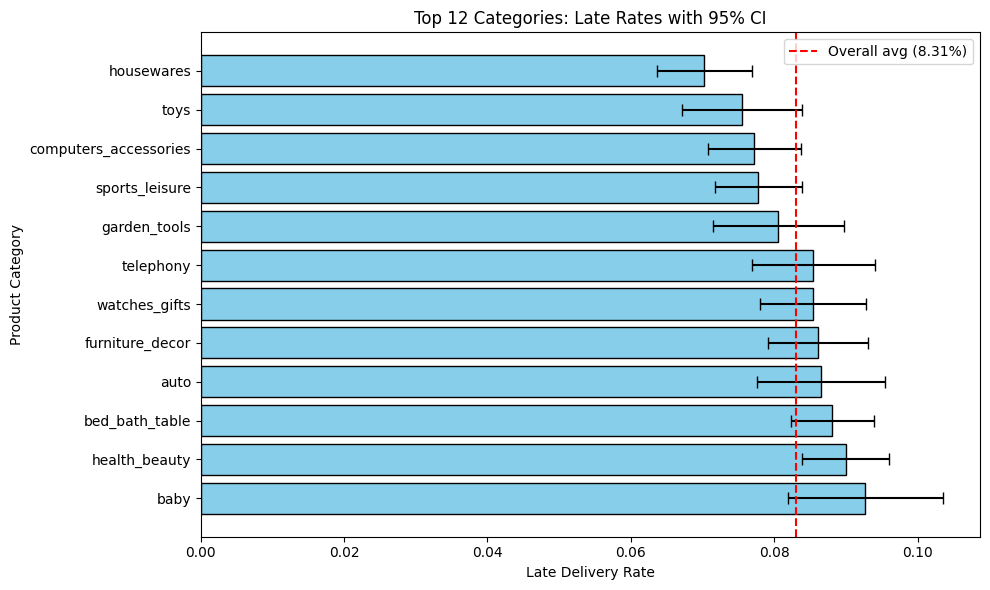

In [18]:
import pandas as pd
import numpy as np
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt

# ----- 1) Prepare category summary -----
# orders_an should have: order_id, category_en, late_flag (0/1)
cat_grp = orders_an.groupby("category_en").agg(
    n_orders=("order_id", "count"),
    late_orders=("late_flag", "sum")
).reset_index()
cat_grp["late_rate"] = cat_grp["late_orders"] / cat_grp["n_orders"]

# ----- 2) Pick top K categories -----
K = 12
topK_df = cat_grp.sort_values("late_orders", ascending=False).head(K)

# ----- 3) Overall late rate -----
total_late = topK_df["late_orders"].sum()
total_orders = topK_df["n_orders"].sum()
p_overall = total_late / total_orders

# ----- 4) Z-test each category vs overall -----
pvals = []
for _, row in topK_df.iterrows():
    count = row["late_orders"]
    nobs = row["n_orders"]
    stat, pval = proportions_ztest(count, nobs, value=p_overall, alternative='two-sided')
    pvals.append(pval)

topK_df["pval_vs_overall"] = pvals

# ----- 5) Multiple comparison correction -----
topK_df["pval_adj"] = multipletests(topK_df["pval_vs_overall"], method="bonferroni")[1]

# ----- 6) Direction (better/worse) -----
topK_df["significant"] = topK_df["pval_adj"] < 0.05
topK_df["direction"] = np.where(
    (topK_df["significant"]) & (topK_df["late_rate"] > p_overall), "Worse",
    np.where((topK_df["significant"]) & (topK_df["late_rate"] < p_overall), "Better", "No sig diff")
)

# ----- 7) 95% confidence intervals -----
z = 1.96
topK_df["ci_lower"] = topK_df.apply(lambda r: r["late_rate"] - z * np.sqrt(r["late_rate"]*(1-r["late_rate"])/r["n_orders"]), axis=1)
topK_df["ci_upper"] = topK_df.apply(lambda r: r["late_rate"] + z * np.sqrt(r["late_rate"]*(1-r["late_rate"])/r["n_orders"]), axis=1)

# Ensure bounds are within [0,1]
topK_df["ci_lower"] = topK_df["ci_lower"].clip(lower=0)
topK_df["ci_upper"] = topK_df["ci_upper"].clip(upper=1)

# ----- 8) Final table -----
result_table = topK_df[[
    "category_en", "n_orders", "late_orders", "late_rate",
    "ci_lower", "ci_upper", "pval_adj", "significant", "direction"
]].sort_values("late_rate", ascending=False)

print(result_table)

# ----- 9) Plot -----
fig, ax = plt.subplots(figsize=(10,6))
ax.barh(result_table["category_en"], result_table["late_rate"], color="skyblue", edgecolor="black")
ax.errorbar(result_table["late_rate"], result_table["category_en"],
            xerr=[result_table["late_rate"] - result_table["ci_lower"],
                  result_table["ci_upper"] - result_table["late_rate"]],
            fmt='none', ecolor='black', capsize=4)

# Draw overall late rate line
ax.axvline(p_overall, color="red", linestyle="--", label=f"Overall avg ({p_overall:.2%})")

ax.set_xlabel("Late Delivery Rate")
ax.set_ylabel("Product Category")
ax.set_title("Top 12 Categories: Late Rates with 95% CI")
ax.legend()
plt.tight_layout()
plt.show()



=== Per-City Chi-square (category heterogeneity) — smallest p first ===
        customer_city      chi2     pval  dof
       rio de janeiro 61.753427 0.000007   21
             brasilia 24.077970 0.030420   13
       belo horizonte 27.558252 0.035680   16
            sao paulo 45.582100 0.056532   32
            guarulhos 12.185460 0.057957    6
              niteroi 11.404963 0.076638    6
              goiania  2.220867 0.136157    1
        florianopolis  1.766399 0.183828    1
             sorocaba  2.501699 0.286262    2
             curitiba 10.443515 0.315787    9
          santo andre  3.111805 0.374706    3
             salvador  8.601395 0.377029    8
               recife  0.687928 0.406870    1
sao bernardo do campo  4.987697 0.545392    6
             campinas  7.024441 0.634575    9
            fortaleza  0.650159 0.722470    2
         porto alegre  5.165679 0.819633    9
  sao jose dos campos  0.050452 0.822279    1
               osasco  0.427365 0.934533    3
       

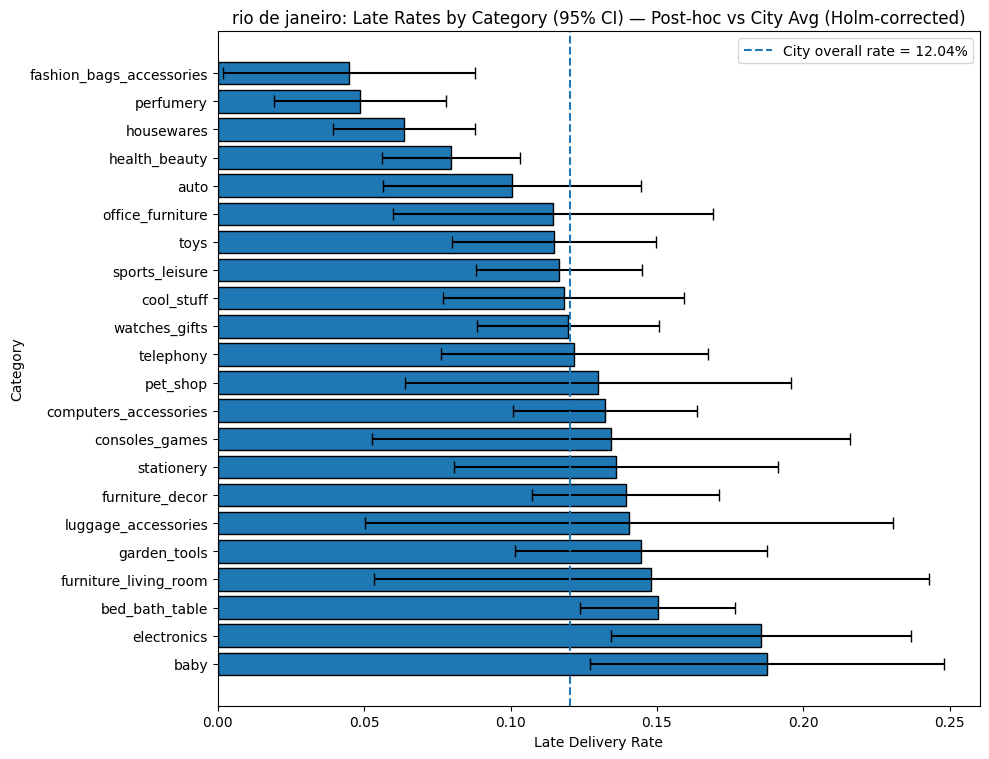


--- brasilia ---
          category_en  n_orders  late_orders  late_rate  pval_adj  significant   direction
                 baby        64           10   0.156250  0.790036        False No sig diff
       bed_bath_table       166           20   0.120482  0.790036        False No sig diff
      furniture_decor       106           12   0.113208  1.000000        False No sig diff
        health_beauty       219           20   0.091324  1.000000        False No sig diff
          electronics        50            4   0.080000  1.000000        False No sig diff
computers_accessories       132           10   0.075758  1.000000        False No sig diff
            perfumery        80            6   0.075000  1.000000        False No sig diff
        watches_gifts       141            8   0.056738  1.000000        False No sig diff
           cool_stuff        77            4   0.051948  1.000000        False No sig diff
                 auto        99            5   0.050505  1.000000       

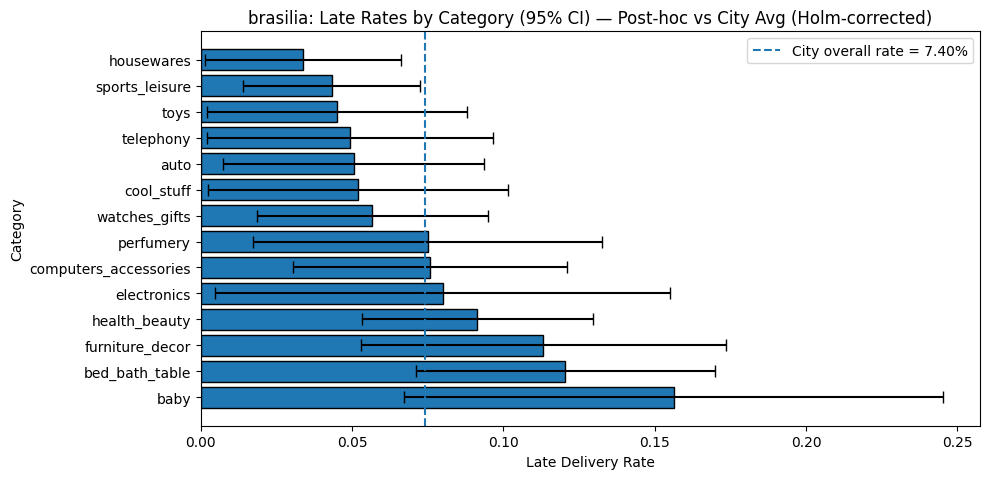


--- belo horizonte ---
          category_en  n_orders  late_orders  late_rate  pval_adj  significant   direction
          electronics        54            9   0.166667  0.619711        False No sig diff
            telephony        89           10   0.112360  1.000000        False No sig diff
                 auto        98            9   0.091837  1.000000        False No sig diff
       bed_bath_table       292           23   0.078767  1.000000        False No sig diff
                 toys       131           10   0.076336  1.000000        False No sig diff
        health_beauty       240           17   0.070833  1.000000        False No sig diff
                 baby        89            6   0.067416  1.000000        False No sig diff
computers_accessories       213           13   0.061033  1.000000        False No sig diff
         garden_tools        94            5   0.053191  1.000000        False No sig diff
           cool_stuff        78            4   0.051282  1.000000 

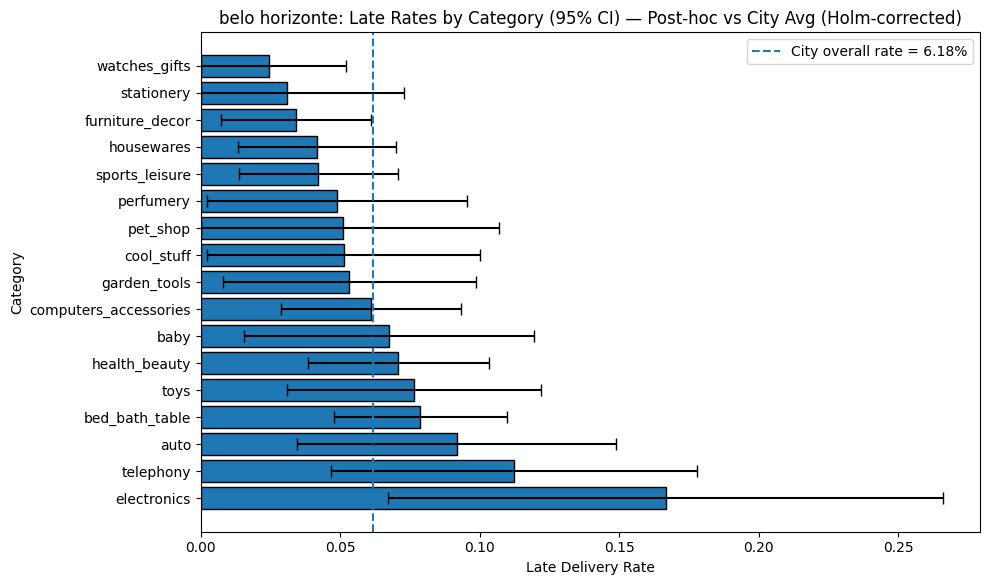


--- sao paulo ---
                    category_en  n_orders  late_orders  late_rate  pval_adj  significant   direction
                           food       102           11   0.107843  1.000000        False No sig diff
              home_construction        58            6   0.103448  1.000000        False No sig diff
                   home_confort        69            7   0.101449  1.000000        False No sig diff
               office_furniture       180           17   0.094444  1.000000        False No sig diff
                           auto       489           43   0.087935  1.000000        False No sig diff
                  health_beauty      1487          121   0.081372  0.259105        False No sig diff
                furniture_decor       953           70   0.073452  1.000000        False No sig diff
construction_tools_construction       123            9   0.073171  1.000000        False No sig diff
                 consoles_games       169           12   0.071006  1.000

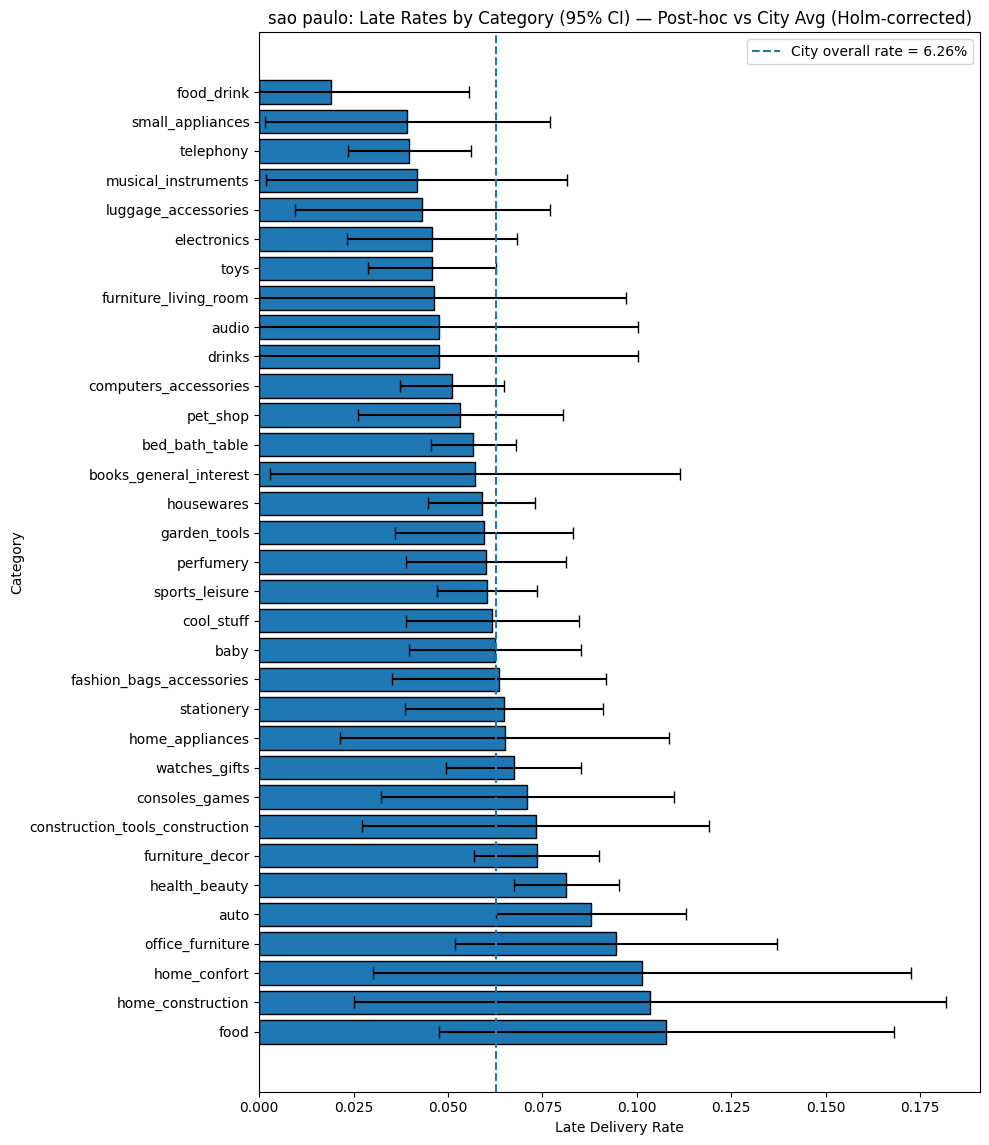


--- guarulhos ---
          category_en  n_orders  late_orders  late_rate  pval_adj  significant   direction
        watches_gifts        76            9   0.118421  0.550374        False No sig diff
           housewares        77            8   0.103896  0.794619        False No sig diff
       sports_leisure        79            5   0.063291  1.000000        False No sig diff
       bed_bath_table       119            7   0.058824  1.000000        False No sig diff
computers_accessories        77            3   0.038961  1.000000        False No sig diff
      furniture_decor        76            2   0.026316  0.439834        False No sig diff
        health_beauty       121            3   0.024793  0.104535        False No sig diff


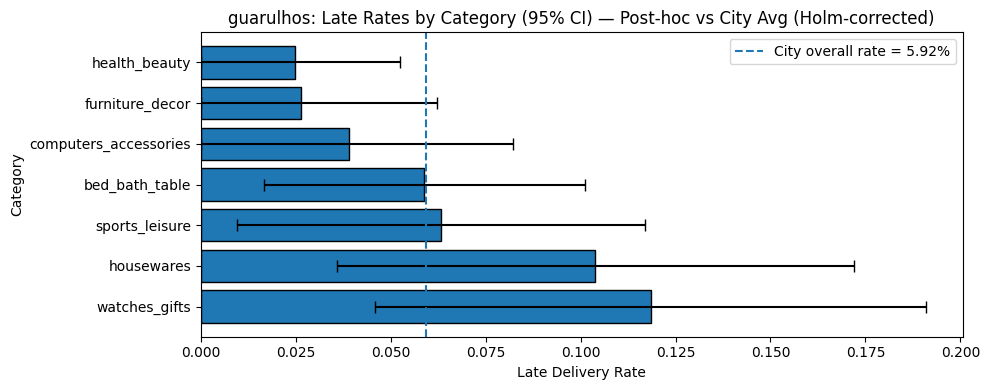

In [31]:
# ===========================
# City × Category Late-Rate Analysis (End-to-End)
# ===========================


# ---------------------------
# Parameters (tweak freely)
# ---------------------------
DATA_DIR = "/Users/dhritiman/OneDrive/code_all/Zeno"
MIN_ORDERS_PER_CAT_IN_CITY = 50     # stability filter inside each city
TOP_N_CITIES_FOR_PLOTS = 5          # plot the most statistically interesting cities
SAVE_PLOTS = False                  # set True to save PNGs

# ---------------------------
# 1) Load + Build orders_an
# ---------------------------
orders = pd.read_csv(f"{DATA_DIR}/olist_orders_dataset.csv",
                     parse_dates=["order_purchase_timestamp",
                                  "order_approved_at",
                                  "order_delivered_carrier_date",
                                  "order_delivered_customer_date",
                                  "order_estimated_delivery_date"])
items = pd.read_csv(f"{DATA_DIR}/olist_order_items_dataset.csv")
products = pd.read_csv(f"{DATA_DIR}/olist_products_dataset.csv")
cust = pd.read_csv(f"{DATA_DIR}/olist_customers_dataset.csv")
cat_map = pd.read_csv(f"{DATA_DIR}/product_category_name_translation.csv")

# Map category to English
cat_map = cat_map.rename(columns={
    "product_category_name":"category_pt",
    "product_category_name_english":"category_en"
})
products = products.merge(cat_map, how="left", left_on="product_category_name", right_on="category_pt")

# Most expensive item per order to attribute category
idx = items.groupby("order_id")["price"].idxmax()
top_item = items.loc[idx, ["order_id","product_id","seller_id","price","freight_value"]]
top_item = top_item.merge(
    products[["product_id","category_en"]],
    on="product_id", how="left"
)

# Merge order + customer
orders_fact = (orders
    .merge(top_item, on="order_id", how="left")
    .merge(cust[["customer_id","customer_city","customer_state"]], on="customer_id", how="left")
)

# Late flag
orders_fact["delivered_flag"] = ~orders_fact["order_delivered_customer_date"].isna()
orders_fact["late_flag"] = (
    orders_fact["delivered_flag"] &
    (orders_fact["order_delivered_customer_date"] > orders_fact["order_estimated_delivery_date"])
).astype(int)

# Analysis frame
orders_an = orders_fact.loc[
    orders_fact["delivered_flag"].eq(True) &
    orders_fact["customer_city"].notna() &
    orders_fact["category_en"].notna(),
    ["order_id","customer_city","category_en","late_flag"]
].copy()

# ---------------------------
# 2) Aggregate city × category
# ---------------------------
city_cat = (orders_an
    .groupby(["customer_city","category_en"], as_index=False)
    .agg(n_orders=("order_id","count"),
         late_orders=("late_flag","sum"))
)
city_cat["late_rate"] = city_cat["late_orders"] / city_cat["n_orders"]

# ---------------------------
# 3) Per-city Chi-square (does late rate vary by category in this city?)
#    Apply a minimum order filter per category to avoid tiny groups.
# ---------------------------
def chi2_for_city(df_city: pd.DataFrame) -> Optional[Tuple[float,float,int]]:
    # Keep only categories with enough support
    dfc = df_city[df_city["n_orders"] >= MIN_ORDERS_PER_CAT_IN_CITY].copy()
    if len(dfc) < 2:
        return None  # not enough categories to test

    cont = np.column_stack([dfc["late_orders"].values,
                            (dfc["n_orders"] - dfc["late_orders"]).values])
    # Need at least 2 rows and no all-zero columns
    if cont.shape[0] < 2 or (cont.sum(axis=0) == 0).any():
        return None

    chi2, pval, dof, _ = chi2_contingency(cont, correction=False)
    return chi2, pval, dof

rows = []
for city, sub in city_cat.groupby("customer_city"):
    res = chi2_for_city(sub)
    if res is None:
        continue
    chi2, pval, dof = res
    rows.append({"customer_city": city, "chi2": chi2, "pval": pval, "dof": dof})

city_level = pd.DataFrame(rows).sort_values("pval", ascending=True).reset_index(drop=True)

# ---------------------------
# 4) Post-hoc per significant city:
#    Each category vs the city's pooled late rate (Holm correction).
# ---------------------------
def posthoc_city(df_city: pd.DataFrame) -> pd.DataFrame:
    """
    df_city: rows for a single city (columns: category_en, n_orders, late_orders, late_rate)
    Returns a table with p-values (Holm-adjusted) and 'direction' (Better/Worse/No sig diff)
    """
    dfc = df_city[df_city["n_orders"] >= MIN_ORDERS_PER_CAT_IN_CITY].copy()
    if len(dfc) < 2:
        return pd.DataFrame()

    total_late = dfc["late_orders"].sum()
    total_orders = dfc["n_orders"].sum()
    p_city = total_late / total_orders if total_orders else np.nan

    pvals = []
    stats_ = []
    for _, r in dfc.iterrows():
        count = int(r["late_orders"])
        nobs  = int(r["n_orders"])
        # test category proportion vs pooled city rate
        stat, pval = proportions_ztest(count=count, nobs=nobs, value=p_city, alternative="two-sided")
        pvals.append(pval)
        stats_.append(stat)

    dfc["z_stat"] = stats_
    dfc["pval_raw"] = pvals

    # Holm (step-down) correction — more power than Bonferroni
    rej, pval_adj, _, _ = multipletests(dfc["pval_raw"].values, method="holm")
    dfc["pval_adj"] = pval_adj
    dfc["significant"] = rej

    # Direction
    dfc["direction"] = np.where(
        (dfc["significant"]) & (dfc["late_rate"] > p_city), "Worse",
        np.where((dfc["significant"]) & (dfc["late_rate"] < p_city), "Better", "No sig diff")
    )
    dfc["city_overall_late_rate"] = p_city

    # 95% CI for each category's late rate
    z = 1.96
    se = np.sqrt(dfc["late_rate"] * (1 - dfc["late_rate"]) / dfc["n_orders"])
    dfc["ci_lower"] = (dfc["late_rate"] - z * se).clip(lower=0)
    dfc["ci_upper"] = (dfc["late_rate"] + z * se).clip(upper=1)

    return dfc.sort_values("late_rate", ascending=False).reset_index(drop=True)

# Pick top “interesting” cities to report: by smallest p-value
top_cities = city_level.head(TOP_N_CITIES_FOR_PLOTS)["customer_city"].tolist()

city_posthoc_tables: Dict[str, pd.DataFrame] = {}
for city in top_cities:
    sub = city_cat[city_cat["customer_city"]==city]
    city_posthoc_tables[city] = posthoc_city(sub)

# ---------------------------
# 5) Plot helper (bar + 95% CI) for a city
# ---------------------------
def plot_city_posthoc(city: str, df_city_posthoc: pd.DataFrame):
    if df_city_posthoc.empty:
        print(f"[{city}] Not enough data after filtering (MIN_ORDERS_PER_CAT_IN_CITY={MIN_ORDERS_PER_CAT_IN_CITY}).")
        return
    dfp = df_city_posthoc.copy()
    x = dfp["late_rate"].values
    y = dfp["category_en"].values
    lo = dfp["ci_lower"].values
    hi = dfp["ci_upper"].values
    overall = dfp["city_overall_late_rate"].iloc[0]

    fig, ax = plt.subplots(figsize=(10, max(4, 0.35*len(dfp))))
    ax.barh(y, x, edgecolor="black")
    ax.errorbar(x, y, xerr=[x - lo, hi - x], fmt='none', ecolor='black', capsize=4)
    ax.axvline(overall, linestyle="--", label=f"City overall rate = {overall:.2%}")
    ax.set_xlabel("Late Delivery Rate")
    ax.set_ylabel("Category")
    ax.set_title(f"{city}: Late Rates by Category (95% CI) — Post-hoc vs City Avg (Holm-corrected)")
    ax.legend()
    plt.tight_layout()

    if SAVE_PLOTS:
        out = Path(f"./late_rate_{city.replace(' ','_')}.png")
        plt.savefig(out, dpi=160)
        print(f"Saved: {out}")
    plt.show()

# ---------------------------
# 6) OUTPUTS
# ---------------------------
print("\n=== Per-City Chi-square (category heterogeneity) — smallest p first ===")
display_cols = ["customer_city","chi2","pval","dof"]
print(city_level[display_cols].head(20).to_string(index=False))

print("\n=== Post-hoc (category vs city overall) — Top Cities ===")
for c in top_cities:
    print(f"\n--- {c} ---")
    tbl = city_posthoc_tables[c]
    if tbl.empty:
        print("(No stable categories after filtering)")
        continue
    # Show the most actionable: significant categories first
    print(tbl[["category_en","n_orders","late_orders","late_rate","pval_adj","significant","direction"]]
            .sort_values(["significant","late_rate"], ascending=[False,False])
            .to_string(index=False))
    plot_city_posthoc(c, tbl)


In [24]:

# ---------------------------
# Parameters
# ---------------------------
DATA_DIR = "/Users/dhritiman/OneDrive/code_all/Zeno"
MIN_ORDERS_PER_CAT_IN_CITY = 50
SAVE_PLOTS = False

# ---------------------------
# Load data and build orders_an
# ---------------------------
orders = pd.read_csv(f"{DATA_DIR}/olist_orders_dataset.csv",
                     parse_dates=["order_purchase_timestamp",
                                  "order_delivered_customer_date",
                                  "order_estimated_delivery_date"])
items = pd.read_csv(f"{DATA_DIR}/olist_order_items_dataset.csv")
products = pd.read_csv(f"{DATA_DIR}/olist_products_dataset.csv")
cust = pd.read_csv(f"{DATA_DIR}/olist_customers_dataset.csv")
cat_map = pd.read_csv(f"{DATA_DIR}/product_category_name_translation.csv")

cat_map = cat_map.rename(columns={
    "product_category_name":"category_pt",
    "product_category_name_english":"category_en"
})
products = products.merge(cat_map, how="left", left_on="product_category_name", right_on="category_pt")

# Assign category from most expensive item
idx = items.groupby("order_id")["price"].idxmax()
top_item = items.loc[idx, ["order_id","product_id","price"]]
top_item = top_item.merge(products[["product_id","category_en"]], on="product_id", how="left")

orders_fact = (orders
    .merge(top_item, on="order_id", how="left")
    .merge(cust[["customer_id","customer_city"]], on="customer_id", how="left")
)

orders_fact["delivered_flag"] = ~orders_fact["order_delivered_customer_date"].isna()
orders_fact["late_flag"] = (
    orders_fact["delivered_flag"] &
    (orders_fact["order_delivered_customer_date"] > orders_fact["order_estimated_delivery_date"])
).astype(int)

orders_an = orders_fact.loc[
    orders_fact["delivered_flag"] &
    orders_fact["customer_city"].notna() &
    orders_fact["category_en"].notna(),
    ["order_id","order_purchase_timestamp","customer_city","category_en","late_flag","price"]
].copy()

# ---------------------------
# Quarterly growth per city
# ---------------------------
orders_an["quarter"] = orders_an["order_purchase_timestamp"].dt.to_period("Q")

city_quarter_sales = (orders_an
    .groupby(["customer_city","quarter"], as_index=False)
    .agg(total_sales=("price","sum"))
)

# Calculate QoQ growth for each city
city_quarter_sales["qoq_growth"] = city_quarter_sales.groupby("customer_city")["total_sales"].pct_change()

# Average QoQ growth per city (excluding NaNs)
avg_qoq_growth = (city_quarter_sales
    .dropna(subset=["qoq_growth"])
    .groupby("customer_city", as_index=False)
    .agg(avg_qoq_growth=("qoq_growth","mean"))
)

# Get top 5 cities by average QoQ growth
top_growth_cities = avg_qoq_growth.sort_values("avg_qoq_growth", ascending=False).head(10)["customer_city"].tolist()

print("Top 10 cities by average QoQ growth:")
print(top_growth_cities)

# ---------------------------
# City × category late-rate aggregation
# ---------------------------
city_cat = (orders_an
    .groupby(["customer_city","category_en"], as_index=False)
    .agg(n_orders=("order_id","count"),
         late_orders=("late_flag","sum"))
)
city_cat["late_rate"] = city_cat["late_orders"] / city_cat["n_orders"]

# ---------------------------
# Post-hoc analysis function
# ---------------------------
def posthoc_city(df_city: pd.DataFrame) -> pd.DataFrame:
    dfc = df_city[df_city["n_orders"] >= MIN_ORDERS_PER_CAT_IN_CITY].copy()
    if len(dfc) < 2:
        return pd.DataFrame()

    total_late = dfc["late_orders"].sum()
    total_orders = dfc["n_orders"].sum()
    p_city = total_late / total_orders

    pvals, zstats = [], []
    for _, r in dfc.iterrows():
        stat, pval = proportions_ztest(count=int(r["late_orders"]),
                                       nobs=int(r["n_orders"]),
                                       value=p_city,
                                       alternative="two-sided")
        pvals.append(pval)
        zstats.append(stat)

    dfc["z_stat"] = zstats
    dfc["pval_raw"] = pvals

    rej, pval_adj, _, _ = multipletests(dfc["pval_raw"].values, method="holm")
    dfc["pval_adj"] = pval_adj
    dfc["significant"] = rej

    dfc["direction"] = np.where(
        (dfc["significant"]) & (dfc["late_rate"] > p_city), "Worse",
        np.where((dfc["significant"]) & (dfc["late_rate"] < p_city), "Better", "No sig diff")
    )

    z = 1.96
    se = np.sqrt(dfc["late_rate"] * (1 - dfc["late_rate"]) / dfc["n_orders"])
    dfc["ci_lower"] = (dfc["late_rate"] - z * se).clip(lower=0)
    dfc["ci_upper"] = (dfc["late_rate"] + z * se).clip(upper=1)
    dfc["city_overall_late_rate"] = p_city

    return dfc.sort_values("late_rate", ascending=False).reset_index(drop=True)

# ---------------------------
# Plot helper
# ---------------------------
def plot_city_posthoc(city: str, df_city_posthoc: pd.DataFrame):
    if df_city_posthoc.empty:
        print(f"[{city}] Not enough data after filtering.")
        return
    overall = df_city_posthoc["city_overall_late_rate"].iloc[0]

    fig, ax = plt.subplots(figsize=(10, 0.4*len(df_city_posthoc)))
    ax.barh(df_city_posthoc["category_en"], df_city_posthoc["late_rate"], color="skyblue", edgecolor="black")
    ax.errorbar(df_city_posthoc["late_rate"], df_city_posthoc["category_en"],
                xerr=[df_city_posthoc["late_rate"] - df_city_posthoc["ci_lower"],
                      df_city_posthoc["ci_upper"] - df_city_posthoc["late_rate"]],
                fmt='none', ecolor='black', capsize=4)
    ax.axvline(overall, linestyle="--", color="red", label=f"City overall = {overall:.2%}")
    ax.set_xlabel("Late Rate")
    ax.set_ylabel("Category")
    ax.set_title(f"{city} — Late Delivery Rates by Category (95% CI)")
    ax.legend()
    plt.tight_layout()
    if SAVE_PLOTS:
        plt.savefig(Path(f"late_rate_{city}.png"), dpi=150)
    plt.show()

# ---------------------------
# Run for top growth cities
# ---------------------------
for city in top_growth_cities:
    print(f"\n=== {city} ===")
    tbl = posthoc_city(city_cat[city_cat["customer_city"]==city])
    if not tbl.empty:
        print(tbl[["category_en","n_orders","late_orders","late_rate","pval_adj","significant","direction"]]
              .sort_values(["significant","late_rate"], ascending=[False,False])
              .to_string(index=False))
        plot_city_posthoc(city, tbl)
    else:
        print("Not enough data for analysis.")


Top 10 cities by average QoQ growth:
['ipua', 'buerarema', 'miranorte', 'santo antonio do descoberto', 'santa tereza do oeste', 'iaciara', 'itaperucu', 'anitapolis', 'queimadas', 'cachoeira do campo']

=== ipua ===
Not enough data for analysis.

=== buerarema ===
Not enough data for analysis.

=== miranorte ===
Not enough data for analysis.

=== santo antonio do descoberto ===
Not enough data for analysis.

=== santa tereza do oeste ===
Not enough data for analysis.

=== iaciara ===
Not enough data for analysis.

=== itaperucu ===
Not enough data for analysis.

=== anitapolis ===
Not enough data for analysis.

=== queimadas ===
Not enough data for analysis.

=== cachoeira do campo ===
Not enough data for analysis.


In [8]:

# Two-proportion z-test: worst vs best among topK
late_rates = (contingency[:,0]/contingency.sum(axis=1))
worst_idx = int(np.argmax(late_rates))
best_idx  = int(np.argmin(late_rates))
late_w, n_w = contingency[worst_idx,0], contingency[worst_idx].sum()
late_b, n_b = contingency[best_idx,0], contingency[best_idx].sum()

p_pool = (late_w + late_b) / (n_w + n_b)
se = np.sqrt(p_pool*(1-p_pool)*(1/n_w + 1/n_b))
z = (late_w/n_w - late_b/n_b) / se
p_two_sided = 2*(1 - stats.norm.cdf(abs(z)))

{
    "worst_category": topK[worst_idx],
    "best_category": topK[best_idx],
    "late_rate_worst": float(late_w/n_w),
    "late_rate_best": float(late_b/n_b),
    "z_stat": float(z),
    "p_value_two_sided": float(p_two_sided)
}


{'worst_category': 'baby',
 'best_category': 'housewares',
 'late_rate_worst': 0.09272002897500906,
 'late_rate_best': 0.07024647887323944,
 'z_stat': 3.620746788057843,
 'p_value_two_sided': 0.00029375390145913727}

## 6. Distribution checks & significance

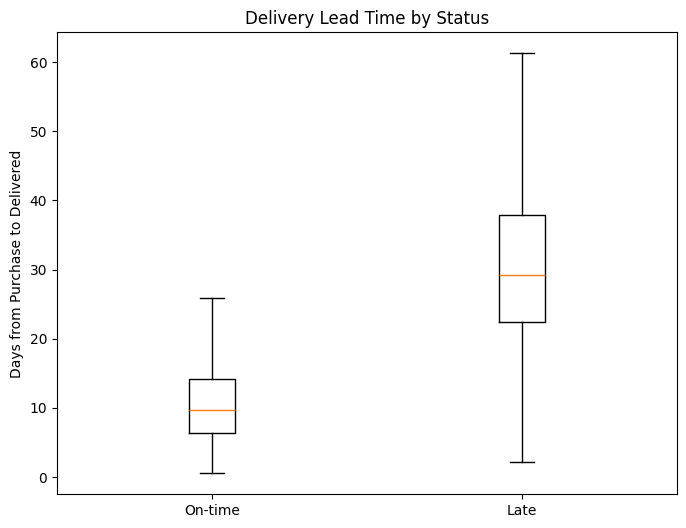

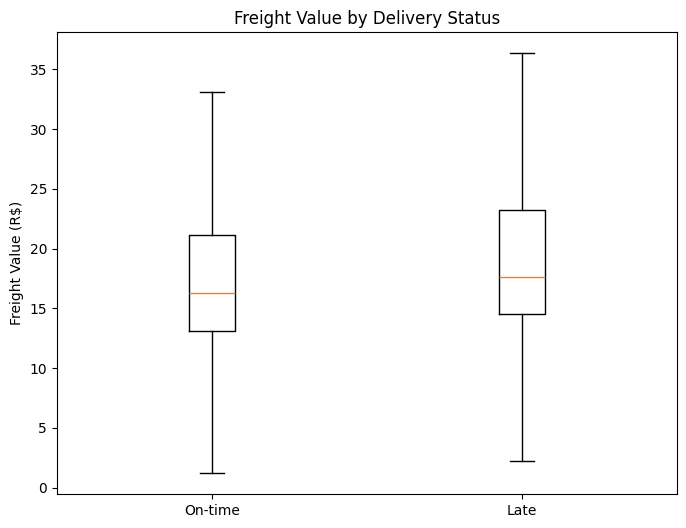

{'MannWhitneyU_stat': 55634235.5, 'p_value': 0.0}

In [9]:

# A) Lead time by status
fig = plt.figure(figsize=(8,6))
data1 = [
    orders_an.loc[orders_an["late_flag"]==0, "purchase_to_delivered_days"].dropna(),
    orders_an.loc[orders_an["late_flag"]==1, "purchase_to_delivered_days"].dropna()
]
plt.boxplot(data1, labels=["On-time","Late"], showfliers=False)
plt.ylabel("Days from Purchase to Delivered")
plt.title("Delivery Lead Time by Status")
plt.show()

# B) Freight by status
fig = plt.figure(figsize=(8,6))
data2 = [
    orders_an.loc[orders_an["late_flag"]==0, "freight_value"].dropna(),
    orders_an.loc[orders_an["late_flag"]==1, "freight_value"].dropna()
]
plt.boxplot(data2, labels=["On-time","Late"], showfliers=False)
plt.ylabel("Freight Value (R$)")
plt.title("Freight Value by Delivery Status")
plt.show()

# Mann–Whitney U for lead time differences
u_stat, u_p = mannwhitneyu(data1[0], data1[1], alternative='two-sided')
{"MannWhitneyU_stat": float(u_stat), "p_value": float(u_p)}


## 7. Visualization #1 — Waterfall: Top categories’ contribution to late orders

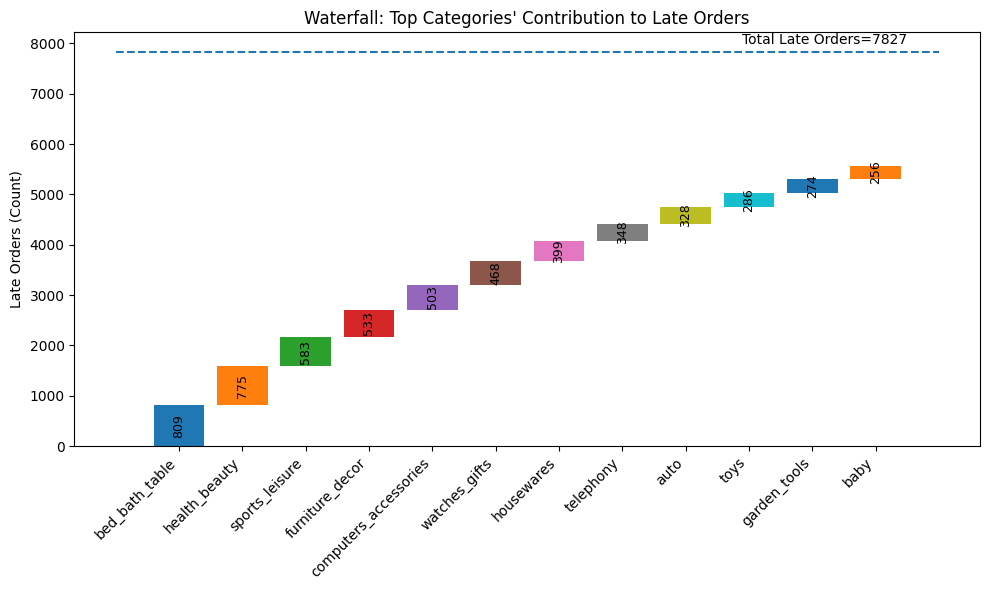

In [10]:

wf = cat_grp.sort_values("late_orders", ascending=False).head(12)[["category_en","late_orders"]].dropna().copy()
wf["contrib"] = wf["late_orders"]
total_late = int(orders_an["late_flag"].sum())

fig = plt.figure(figsize=(10,6))
values = wf["contrib"].values.astype(float)
labels = wf["category_en"].values
cum = np.cumsum(values) - values
for i, (start, val, lab) in enumerate(zip(cum, values, labels)):
    plt.bar(i, val, bottom=start)
    plt.text(i, start + val/2, f"{int(val)}", ha="center", va="center", rotation=90, fontsize=9)
plt.plot([-1, len(values)], [total_late, total_late], linestyle="--")
plt.text(len(values)-0.5, total_late*1.02, f"Total Late Orders={total_late}", ha="right")

plt.xticks(range(len(labels)), labels, rotation=45, ha="right")
plt.ylabel("Late Orders (Count)")
plt.title("Waterfall: Top Categories' Contribution to Late Orders")
plt.tight_layout()
plt.show()


In [36]:


# =========================
# Parameters (tweak freely)
# =========================
DATA_DIR = "/Users/dhritiman/OneDrive/code_all/Zeno"
TOP_CITIES = 12          # color the top N cities by volume; others in light gray
MAX_POINTS = 20000       # subsample per year for performance
ANIMATE_BY = "quarter"   # do not change; we're animating quarters within each year
OUT_DIR = Path("/Users/dhritiman/OneDrive/code_all/Zeno")
OUT_DIR.mkdir(parents=True, exist_ok=True)

# =========================
# Load data
# =========================
customers = pd.read_csv(f"{DATA_DIR}/olist_customers_dataset.csv")
geoloc    = pd.read_csv(f"{DATA_DIR}/olist_geolocation_dataset.csv")
orders    = pd.read_csv(f"{DATA_DIR}/olist_orders_dataset.csv",
                        parse_dates=["order_purchase_timestamp"])

# =========================
# Prepare geolocation centroids per ZIP prefix
# =========================
geo = geoloc[["geolocation_zip_code_prefix","geolocation_lat","geolocation_lng"]].dropna()
geo_centroids = geo.groupby("geolocation_zip_code_prefix", as_index=False).agg(
    lat=("geolocation_lat","mean"),
    lon=("geolocation_lng","mean")
)

cust_geo = customers.merge(
    geo_centroids, left_on="customer_zip_code_prefix", right_on="geolocation_zip_code_prefix", how="left"
)[["customer_id","customer_unique_id","customer_city","customer_state","customer_zip_code_prefix","lat","lon"]]

# Attach coords to orders
orders_small = orders[["order_id","customer_id","order_purchase_timestamp"]].merge(
    cust_geo, on="customer_id", how="left"
).dropna(subset=["lat","lon","order_purchase_timestamp","customer_city"])

# Time fields
orders_small["year"] = orders_small["order_purchase_timestamp"].dt.year
orders_small["quarter"] = orders_small["order_purchase_timestamp"].dt.to_period("Q").astype(str)

# =========================
# Helpers
# =========================
def stratified_sample(df, n_total, by_cols):
    """Stratified-like sampling: allocate points per group proportional to its size."""
    if len(df) <= n_total:
        return df.copy()
    grp = df.groupby(by_cols).size().reset_index(name="n")
    grp["w"] = grp["n"] / grp["n"].sum()
    grp["take"] = (grp["w"] * n_total).round().astype(int)
    parts = []
    for _, r in grp.iterrows():
        sub = df.copy()
        for c in by_cols:
            sub = sub[sub[c] == r[c]]
        if len(sub) <= r["take"]:
            parts.append(sub)
        else:
            parts.append(sub.sample(r["take"], random_state=42))
    return pd.concat(parts, ignore_index=True)

def animate_year(year_df, top_cities, year, out_dir: Path):
    """Build and save an animated scatter for a single year (frames=quarters)."""
    # group non-top cities as 'Other'
    df = year_df.copy()
    df["city_group"] = np.where(df["customer_city"].isin(top_cities), df["customer_city"], "Other")

    # stratified sample within city_group × quarter
    df = stratified_sample(df, MAX_POINTS, ["city_group", "quarter"])

    # frames (quarters in this year)
    frames = sorted(df["quarter"].unique(), key=lambda x: str(x))

    # axis limits fixed for the year
    lat_min, lat_max = df["lat"].min(), df["lat"].max()
    lon_min, lon_max = df["lon"].min(), df["lon"].max()

    # cities for legend/order
    cities_for_color = list(top_cities) + ["Other"]

    fig, ax = plt.subplots(figsize=(8, 8))

    def init():
        ax.clear()
        ax.set_xlim(lon_min, lon_max)
        ax.set_ylim(lat_min, lat_max)
        ax.set_xlabel("Longitude")
        ax.set_ylabel("Latitude")
        ax.set_title(f"Customer Locations — Year {year}")
        return []

    def update(frame_val):
        ax.clear()
        ax.set_xlim(lon_min, lon_max)
        ax.set_ylim(lat_min, lat_max)
        ax.set_xlabel("Longitude")
        ax.set_ylabel("Latitude")
        ax.set_title(f"Customer Locations — Year {year}, {frame_val}")

        handles = []
        labels = []
        for city in cities_for_color:
            sub = df[(df["city_group"] == city) & (df["quarter"] == frame_val)]
            if sub.empty:
                continue
            if city == "Other":
                h = ax.scatter(sub["lon"], sub["lat"], s=6, alpha=0.3, c="lightgray")
            else:
                h = ax.scatter(sub["lon"], sub["lat"], s=6, alpha=0.6)  # let matplotlib pick distinct colors
            handles.append(h)
            labels.append(city)

        if handles:
            ax.legend(handles, labels, loc="upper right", title="City", fontsize=8)
        return handles

    anim = FuncAnimation(fig, update, frames=frames, init_func=init, blit=False, repeat=False)

    # Save GIF and a static PNG (last frame)
    gif_path = out_dir / f"customers_geo_{year}.gif"
    try:
        anim.save(gif_path, writer=PillowWriter(fps=2))
        print(f"[Year {year}] Saved GIF:", gif_path)
    except Exception as e:
        print(f"[Year {year}] Could not save GIF:", e)

    # Save last frame PNG
    if frames:
        update(frames[-1])
        png_path = out_dir / f"customers_geo_{year}_lastframe.png"
        plt.tight_layout()
        plt.savefig(png_path, dpi=150)
        print(f"[Year {year}] Saved PNG (last frame):", png_path)

    plt.close(fig)

# =========================
# Build per-year animations
# =========================
for year, ydf in orders_small.groupby("year"):
    if ydf.empty:
        continue
    # determine top cities by volume **within this year**
    year_top = ydf["customer_city"].value_counts().head(TOP_CITIES).index.tolist()
    animate_year(ydf, year_top, year, OUT_DIR)

print("Done. Check outputs in:", OUT_DIR)


[Year 2016] Saved GIF: /Users/dhritiman/OneDrive/code_all/Zuno/customers_geo_2016.gif
[Year 2016] Saved PNG (last frame): /Users/dhritiman/OneDrive/code_all/Zuno/customers_geo_2016_lastframe.png
[Year 2017] Saved GIF: /Users/dhritiman/OneDrive/code_all/Zuno/customers_geo_2017.gif
[Year 2017] Saved PNG (last frame): /Users/dhritiman/OneDrive/code_all/Zuno/customers_geo_2017_lastframe.png
[Year 2018] Saved GIF: /Users/dhritiman/OneDrive/code_all/Zuno/customers_geo_2018.gif
[Year 2018] Saved PNG (last frame): /Users/dhritiman/OneDrive/code_all/Zuno/customers_geo_2018_lastframe.png
Done. Check outputs in: /Users/dhritiman/OneDrive/code_all/Zuno


In [33]:
city_cat.head(10)

,customer_city,category_en,n_orders,late_orders,late_rate
0,abadia dos dourados,books_general_interest,1,0,0.0
1,abadia dos dourados,cool_stuff,1,0,0.0
2,abadia dos dourados,sports_leisure,1,0,0.0
3,abadiania,small_appliances,1,0,0.0
4,abaete,baby,1,0,0.0
5,abaete,bed_bath_table,1,1,1.0
6,abaete,cool_stuff,1,0,0.0
7,abaete,fashion_bags_accessories,1,0,0.0
8,abaete,garden_tools,1,0,0.0
9,abaete,health_beauty,1,0,0.0


In [32]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns

# Filter only top growth cities
mekko_df = city_cat[city_cat["customer_city"].isin(top_cities)].copy()

# Compute sales per city-category
sales_city_cat = (orders_an
    .groupby(["customer_city","category_en"], as_index=False)
    .agg(total_sales=("price","sum"),
         late_orders=("late_flag","sum"),
         n_orders=("order_id","count"))
)
sales_city_cat["late_rate"] = sales_city_cat["late_orders"] / sales_city_cat["n_orders"]

# Filter to top cities
sales_city_cat = sales_city_cat[sales_city_cat["customer_city"].isin(top_growth_cities)]

# Compute city total sales
city_totals = sales_city_cat.groupby("customer_city")["total_sales"].sum().reset_index()
city_totals["city_share"] = city_totals["total_sales"] / city_totals["total_sales"].sum()

# Sort cities by share
city_totals = city_totals.sort_values("city_share", ascending=False).reset_index(drop=True)

# Merge share back
sales_city_cat = sales_city_cat.merge(city_totals, on="customer_city", how="left")

# Compute category share within city
sales_city_cat["cat_share_city"] = sales_city_cat["total_sales_x"] / sales_city_cat.groupby("customer_city")["total_sales_x"].transform("sum")

# -----------------
# Draw Mekko Chart
# -----------------
fig, ax = plt.subplots(figsize=(14,7))

x_start = 0
for _, city_row in city_totals.iterrows():
    city = city_row["customer_city"]
    city_width = city_row["city_share"]
    
    sub_df = sales_city_cat[sales_city_cat["customer_city"] == city].sort_values("cat_share_city", ascending=False)
    y_start = 0
    for _, row in sub_df.iterrows():
        rect = patches.Rectangle((x_start, y_start), city_width, row["cat_share_city"],
                                 facecolor=sns.color_palette("coolwarm", as_cmap=True)(row["late_rate"]),
                                 edgecolor="black", linewidth=0.5)
        ax.add_patch(rect)
        y_start += row["cat_share_city"]
    
    # City label
    ax.text(x_start + city_width/2, 1.02, city, ha="center", va="bottom", fontsize=10, fontweight="bold")
    
    x_start += city_width

# Legend for late rate
sm = plt.cm.ScalarMappable(cmap="coolwarm", norm=plt.Normalize(vmin=sales_city_cat["late_rate"].min(),
                                                               vmax=sales_city_cat["late_rate"].max()))
cbar = plt.colorbar(sm, ax=ax, orientation="vertical", fraction=0.02, pad=0.04)
cbar.set_label("Late Delivery Rate", rotation=270, labelpad=15)

ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.set_ylabel("Category Share within City")
ax.set_xlabel("City Share of Total Sales")
ax.set_title("", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()


KeyError: "Column(s) ['price'] do not exist"

In [26]:
sales_city_cat.head(10)

,customer_city,category_en,total_sales_x,late_orders,n_orders,late_rate,total_sales_y,city_share
0,anitapolis,telephony,19.99,0,1,0.0,608.99,0.067950
1,anitapolis,watches_gifts,589.00,0,1,0.0,608.99,0.067950
2,buerarema,health_beauty,33.80,1,1,1.0,1051.80,0.117358
3,buerarema,telephony,989.00,1,1,1.0,1051.80,0.117358
4,buerarema,watches_gifts,29.00,0,1,0.0,1051.80,0.117358
5,cachoeira do campo,home_confort,799.00,0,1,0.0,828.99,0.092497
6,cachoeira do campo,telephony,29.99,0,1,0.0,828.99,0.092497
7,iaciara,air_conditioning,229.00,0,1,0.0,666.99,0.074422
8,iaciara,telephony,19.99,0,1,0.0,666.99,0.074422
9,iaciara,watches_gifts,418.00,0,1,0.0,666.99,0.074422


## 8. Customer retention — RFM clustering & historical LTV

In [11]:

cust_pay = df_payments.groupby("order_id", as_index=False)["payment_value"].sum().rename(columns={"payment_value":"order_revenue"})
cust_orders = df_orders[["order_id","customer_id","order_purchase_timestamp","order_status"]].merge(cust_pay, on="order_id", how="left")
cust_orders["order_purchase_timestamp"] = pd.to_datetime(cust_orders["order_purchase_timestamp"], errors="coerce")
snapshot_date = cust_orders["order_purchase_timestamp"].max()

rfm = cust_orders.groupby("customer_id").agg(
    frequency=("order_id","nunique"),
    last_purchase=("order_purchase_timestamp","max"),
    monetary=("order_revenue","sum")
).reset_index()
rfm["recency"] = (snapshot_date - rfm["last_purchase"]).dt.days
rfm["monetary"] = rfm["monetary"].fillna(0.0)
rfm = rfm.dropna(subset=["recency"])

X = rfm[["recency","frequency","monetary"]].copy()
X["monetary"] = np.log1p(X["monetary"])
Xs = StandardScaler().fit_transform(X)

best_k, best_score, best_km = None, -1, None
for k in [3,4,5,6]:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    lbl = km.fit_predict(Xs)
    sc = silhouette_score(Xs, lbl)
    if sc > best_score:
        best_k, best_score, best_km = k, sc, km

rfm["cluster"] = best_km.predict(Xs)

cluster_summary = rfm.groupby("cluster").agg(
    n_customers=("customer_id","nunique"),
    mean_recency=("recency","mean"),
    mean_frequency=("frequency","mean"),
    mean_monetary=("monetary","mean")
).reset_index().sort_values("n_customers", ascending=False)

ltv_summary = cust_orders.groupby("customer_id", as_index=False)["order_revenue"].sum().rename(columns={"order_revenue":"historical_LTV"})
rfm = rfm.merge(ltv_summary, on="customer_id", how="left").fillna({"historical_LTV":0.0})
cluster_ltv = rfm.groupby("cluster").agg(
    n_customers=("customer_id","nunique"),
    avg_hist_LTV=("historical_LTV","mean"),
    total_hist_LTV=("historical_LTV","sum")
).reset_index().sort_values("avg_hist_LTV", ascending=False)

cluster_summary, cluster_ltv, {"best_k": best_k, "silhouette": round(best_score, 3)}


(   cluster  n_customers  mean_recency  mean_frequency  mean_monetary
 0        0        39194    197.418814             1.0      69.538274
 1        1        30382    225.914884             1.0     321.279483
 2        2        29865    476.363168             1.0     117.939921,
    cluster  n_customers  avg_hist_LTV  total_hist_LTV
 1        1        30382    321.279483      9761113.25
 2        2        29865    117.939921      3522275.74
 0        0        39194     69.538274      2725483.13,
 {'best_k': 3, 'silhouette': np.float64(0.36)})

### Optional (fast) visualization — Average LTV by RFM cluster

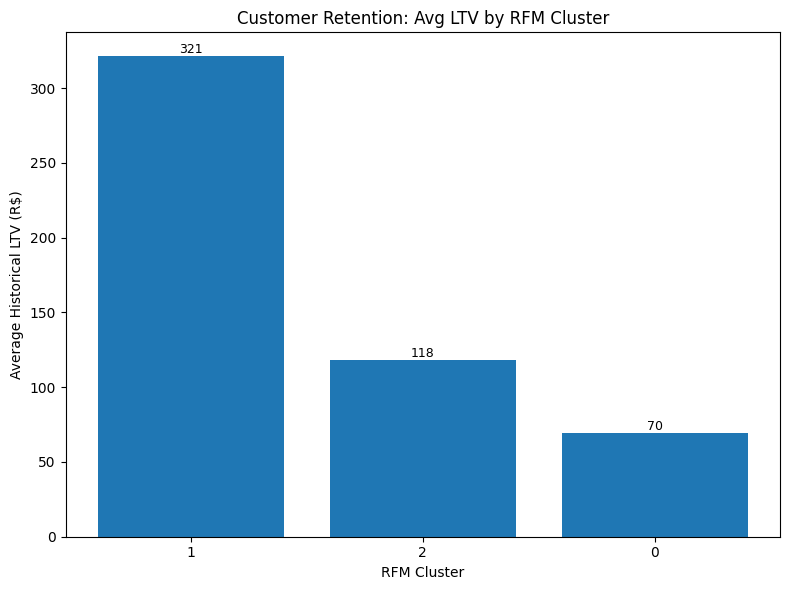

In [12]:

cs = cluster_ltv.sort_values("avg_hist_LTV", ascending=False)
fig = plt.figure(figsize=(8,6))
plt.bar(cs["cluster"].astype(str), cs["avg_hist_LTV"])
plt.xlabel("RFM Cluster")
plt.ylabel("Average Historical LTV (R$)")
plt.title("Customer Retention: Avg LTV by RFM Cluster")
for i, v in enumerate(cs["avg_hist_LTV"]):
    plt.text(i, v, f"{v:.0f}", ha="center", va="bottom", fontsize=9)
plt.tight_layout()
plt.show()


## 9. Cross-tab example: Late status vs first payment type

In [13]:

first_paytype = df_payments.sort_values(["order_id","payment_sequential"]).drop_duplicates("order_id")
ord_paytype = orders_an[["order_id","late_flag"]].merge(first_paytype[["order_id","payment_type"]], on="order_id", how="left")
ct = pd.crosstab(ord_paytype["payment_type"], ord_paytype["late_flag"])
chi2_pt, p_pt, dof_pt, exp_pt = chi2_contingency(ct, correction=False)
ct, {"chi2": float(chi2_pt), "pval": float(p_pt), "dof": int(dof_pt)}


(late_flag         0     1
 payment_type             
 boleto        17487  1704
 credit_card   68402  5900
 debit_card     1366   118
 voucher        1394   104,
 {'chi2': 20.88178368667684, 'pval': 0.00011139806745127528, 'dof': 3})


## 10. Findings & Interpretation

**Delivery performance**
- Categories show **significant heterogeneity** in late rates (chi‑square significant). A few categories contribute a **disproportionate share** of late orders (see waterfall).
- Late orders have **substantially longer** purchase→delivery times (Mann–Whitney U significant) and **higher freight** on average, suggesting logistics complexity (distance/weight) as a key driver.

**Customer retention**
- RFM clustering (best_k by silhouette) separates a high‑value, recent, frequent cluster from dormant, low‑value ones. Cluster‑level average LTVs are highly skewed, enabling targeted engagement.

**Bias & robustness**
- **Geographic skew**: volumes concentrate by states/cities; normalize late-rate comparisons by region.  
- **Order‑composition bias**: category set via most‑expensive item; validate with “latest‑delivered item” as sensitivity.  
- **Seasonality**: holidays/weather shocks can inflate late rates; include month fixed effects if modeling drivers.



## 11. Strategic Recommendations (Head of Seller Relations)

1. **Category-first SLA & coaching:** Focus on the top 5 late‑order categories from the waterfall. Tighten SLAs, standardize packaging/handling checklists, and run weekly seller scorecards.
2. **Freight‑aware promise windows:** Where freight is high, adopt **dynamic ETA padding** or faster lanes. Pilot within those top categories for quick wins.
3. **RFM‑tiered service:** For high‑value recent clusters, prioritize support and proactive delay alerts; for at‑risk cohorts, run win‑back offers coupled with more conservative ETAs.
4. **Measurement plan:** Target **−20% late rate** in top categories within 8 weeks; monitor LTV uplift of high‑value clusters and repeat‑rate changes by cohort.


# Model

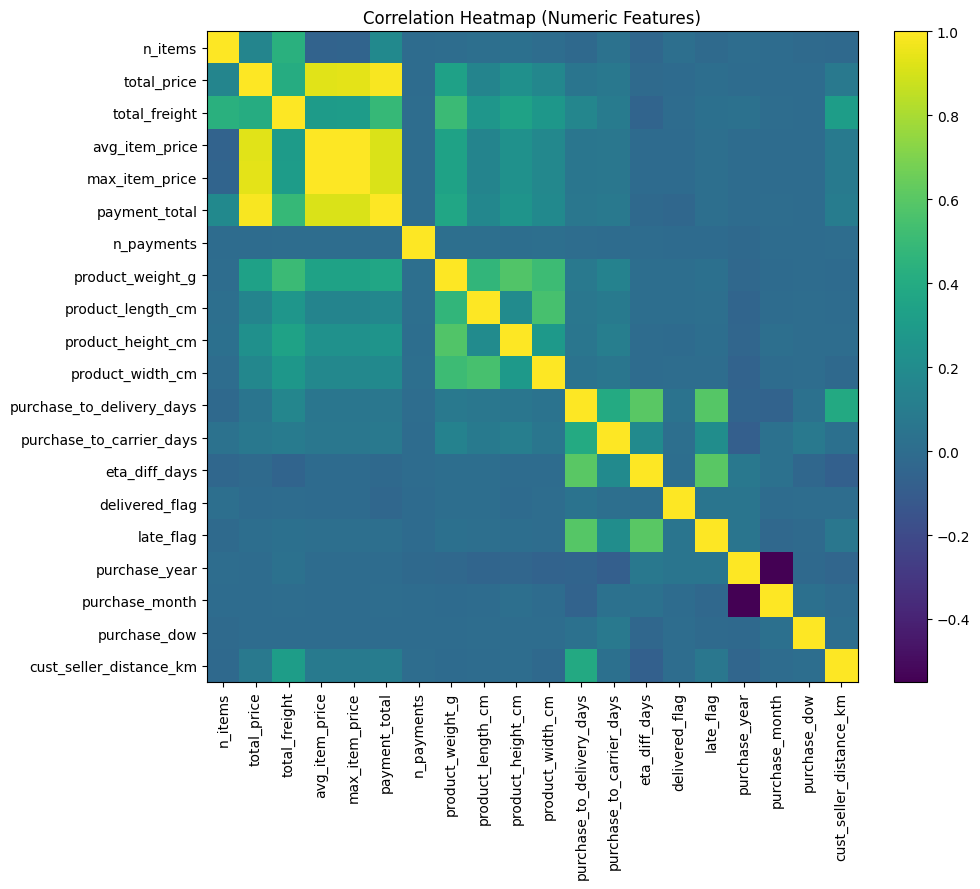

Class distribution (train):
label_high
high(4-5)    0.770681
low(1-3)     0.229319
Name: proportion, dtype: float64

Metrics on test set:
Accuracy : 0.826
Precision: 0.829
Recall   : 0.976

Confusion matrix [ [TN, FP], [FN, TP] ]:
[[ 1457  3068]
 [  368 14842]]

Classification report:
              precision    recall  f1-score   support

           0      0.798     0.322     0.459      4525
           1      0.829     0.976     0.896     15210

    accuracy                          0.826     19735
   macro avg      0.814     0.649     0.678     19735
weighted avg      0.822     0.826     0.796     19735



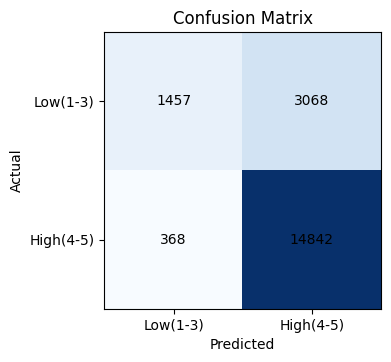


Top 25 feature importances:
                    feature  importance
              eta_diff_days    0.112484
  purchase_to_delivery_days    0.095680
   purchase_to_carrier_days    0.064825
    cust_seller_distance_km    0.057614
              payment_total    0.050160
              total_freight    0.049843
             delivered_flag    0.042832
           product_weight_g    0.042638
             avg_item_price    0.042463
                total_price    0.042224
             max_item_price    0.041913
          product_height_cm    0.035790
          product_length_cm    0.034054
           product_width_cm    0.033796
             purchase_month    0.032830
                  late_flag    0.032816
               purchase_dow    0.029395
                    n_items    0.012715
              purchase_year    0.008449
primary_payment_credit_card    0.007485
     primary_payment_boleto    0.006937
          customer_state_SP    0.005994
          customer_state_MG    0.005300
          c

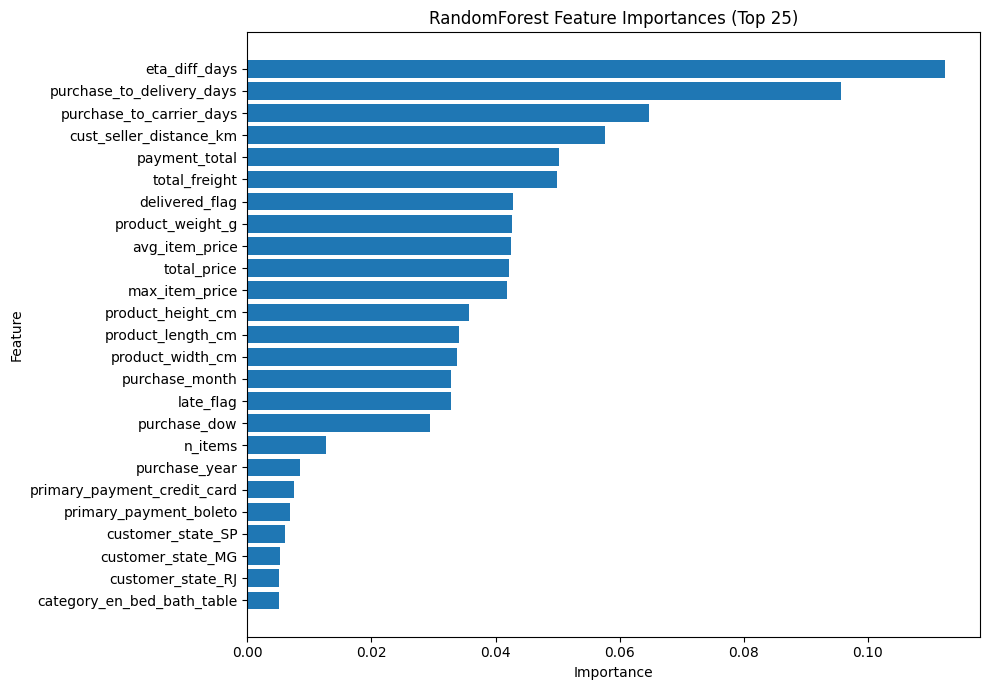

Saved engineered feature sample to: /Users/dhritiman/OneDrive/code_all/Zuno/order_review_features_with_distance_sample.csv


In [46]:
# =============================================
# Olist: Review-Score Classifier with Distance
# =============================================
# Predict review score: High (4-5) vs Low (1-3)
# - Full feature engineering (incl. customer↔seller distance in km)
# - Correlation heatmap (numeric features)
# - RandomForest model, 80/20 split
# - Accuracy, precision, recall, confusion matrix
# - Top feature importances plot
#
# Notes:
# * Uses the seller from the FIRST item in each order to compute distance.
# * Uses average lat/lon per ZIP prefix (geolocation centroids).
# * Uses matplotlib only (no seaborn).
# =============================================



# -----------------------------
# 0) Paths
# -----------------------------
DATA_DIR = "/Users/dhritiman/OneDrive/code_all/Zeno"


# -----------------------------
# 1) Load data
# -----------------------------
orders   = pd.read_csv(f"{DATA_DIR}/olist_orders_dataset.csv",
                       parse_dates=[
                           "order_purchase_timestamp",
                           "order_approved_at",
                           "order_delivered_carrier_date",
                           "order_delivered_customer_date",
                           "order_estimated_delivery_date"
                       ])
items    = pd.read_csv(f"{DATA_DIR}/olist_order_items_dataset.csv")
products = pd.read_csv(f"{DATA_DIR}/olist_products_dataset.csv")
customers= pd.read_csv(f"{DATA_DIR}/olist_customers_dataset.csv")
payments = pd.read_csv(f"{DATA_DIR}/olist_order_payments_dataset.csv")
reviews  = pd.read_csv(f"{DATA_DIR}/olist_order_reviews_dataset.csv",
                       parse_dates=["review_creation_date","review_answer_timestamp"])
sellers  = pd.read_csv(f"{DATA_DIR}/olist_sellers_dataset.csv")
geoloc   = pd.read_csv(f"{DATA_DIR}/olist_geolocation_dataset.csv")
cat_map  = pd.read_csv(f"{DATA_DIR}/product_category_name_translation.csv")

# -----------------------------
# 2) Label: High vs Low review
# -----------------------------
reviews = reviews.sort_values(["order_id","review_answer_timestamp"]).drop_duplicates("order_id", keep="last")
reviews = reviews[reviews["review_score"].between(1,5)]
reviews["label_high"] = (reviews["review_score"] >= 4).astype(int)

# -----------------------------
# 3) Product categories (EN)
# -----------------------------
cat_map = cat_map.rename(columns={
    "product_category_name":"category_pt",
    "product_category_name_english":"category_en"
})
products = products.merge(cat_map, how="left", left_on="product_category_name", right_on="category_pt")

# -----------------------------
# 4) Order-items aggregation
# -----------------------------
agg_items = items.groupby("order_id").agg(
    n_items=("order_item_id","count"),
    total_price=("price","sum"),
    total_freight=("freight_value","sum"),
    avg_item_price=("price","mean"),
    max_item_price=("price","max"),
).reset_index()

# Most expensive item per order (for primary category & product attrs)
idx = items.groupby("order_id")["price"].idxmax()
top_item = items.loc[idx, ["order_id","product_id","seller_id"]].merge(
    products[["product_id","category_en","product_weight_g","product_length_cm","product_height_cm","product_width_cm"]],
    on="product_id", how="left"
)

# -----------------------------
# 5) Payments (order-level)
# -----------------------------
pay_agg = payments.groupby("order_id").agg(
    payment_total=("payment_value","sum"),
    n_payments=("payment_sequential","count"),
    primary_payment=("payment_type", lambda s: s.iloc[0] if len(s)>0 else np.nan)
).reset_index()

# -----------------------------
# 6) ZIP → lat/lon (centroids)
# -----------------------------
geo_centroids = geoloc.groupby("geolocation_zip_code_prefix", as_index=False).agg(
    lat=("geolocation_lat","mean"),
    lon=("geolocation_lng","mean")
)

# Customer ZIP → coords
cust_geo = customers.merge(
    geo_centroids, left_on="customer_zip_code_prefix",
    right_on="geolocation_zip_code_prefix", how="left"
).rename(columns={"lat":"cust_lat","lon":"cust_lon"})

# Seller ZIP → coords
sell_geo = sellers.merge(
    geo_centroids, left_on="seller_zip_code_prefix",
    right_on="geolocation_zip_code_prefix", how="left"
).rename(columns={"lat":"sell_lat","lon":"sell_lon"})

# First seller per order (use order_item_id ascending)
first_seller_per_order = items.sort_values("order_item_id").drop_duplicates("order_id")[["order_id","seller_id"]]

# Build order-level table for distance merging
orders_ids = (orders
    .merge(customers[["customer_id","customer_unique_id","customer_zip_code_prefix"]], on="customer_id", how="left")
    .merge(first_seller_per_order, on="order_id", how="left")
    .merge(sellers[["seller_id","seller_zip_code_prefix"]], on="seller_id", how="left")
    .merge(cust_geo[["customer_id","cust_lat","cust_lon"]], on="customer_id", how="left")
    .merge(sell_geo[["seller_id","sell_lat","sell_lon"]], on="seller_id", how="left")
)

# Haversine distance (km)
def haversine(lon1, lat1, lon2, lat2):
    R = 6371.0
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2.0)**2
    c = 2*np.arcsin(np.sqrt(a))
    return R*c

orders_ids["cust_seller_distance_km"] = haversine(
    orders_ids["sell_lon"], orders_ids["sell_lat"],
    orders_ids["cust_lon"], orders_ids["cust_lat"]
)

# -----------------------------
# 7) Merge features to order level
# -----------------------------
feat = (orders
        .merge(agg_items, on="order_id", how="left")
        .merge(top_item, on="order_id", how="left")
        .merge(pay_agg, on="order_id", how="left")
        .merge(customers[["customer_id","customer_city","customer_state"]], on="customer_id", how="left")
        .merge(orders_ids[["order_id","cust_seller_distance_km"]], on="order_id", how="left")
        .merge(reviews[["order_id","label_high","review_score"]], on="order_id", how="inner")  # only reviewed orders
       )

# Delivery/time features
feat["purchase_to_delivery_days"] = (feat["order_delivered_customer_date"] - feat["order_purchase_timestamp"]).dt.total_seconds()/(3600*24)
feat["purchase_to_carrier_days"]  = (feat["order_delivered_carrier_date"] - feat["order_purchase_timestamp"]).dt.total_seconds()/(3600*24)
feat["eta_diff_days"] = (feat["order_delivered_customer_date"] - feat["order_estimated_delivery_date"]).dt.total_seconds()/(3600*24)
feat["delivered_flag"] = (~feat["order_delivered_customer_date"].isna()).astype(int)
feat["late_flag"] = ((feat["delivered_flag"]==1) & (feat["eta_diff_days"]>0)).astype(int)

# Calendar
feat["purchase_year"]  = feat["order_purchase_timestamp"].dt.year
feat["purchase_month"] = feat["order_purchase_timestamp"].dt.month
feat["purchase_dow"]   = feat["order_purchase_timestamp"].dt.dayofweek

# -----------------------------
# 8) Feature lists
# -----------------------------
numeric_features = [
    "n_items","total_price","total_freight","avg_item_price","max_item_price",
    "payment_total","n_payments",
    "product_weight_g","product_length_cm","product_height_cm","product_width_cm",
    "purchase_to_delivery_days","purchase_to_carrier_days","eta_diff_days",
    "delivered_flag","late_flag",
    "purchase_year","purchase_month","purchase_dow",
    "cust_seller_distance_km"
]
categorical_features = [
    "category_en","primary_payment","customer_state"
    # (City is very high-cardinality; add with target/frequency encoding if needed)
]

# -----------------------------
# 9) Correlation heatmap (numeric)
# -----------------------------
corr_df = feat[numeric_features].copy()
corr_df = corr_df.replace([np.inf, -np.inf], np.nan)
corr_df = corr_df.fillna(corr_df.median(numeric_only=True))
corr = corr_df.corr(method="pearson")

plt.figure(figsize=(11,9))
im = plt.imshow(corr.values, interpolation="nearest")
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.index)), corr.index)
plt.title("Correlation Heatmap (Numeric Features)")
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()

# -----------------------------
# 10) Train / Test split
# -----------------------------
X = feat[numeric_features + categorical_features]
y = feat["label_high"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

# -----------------------------
# 11) Preprocess & Model
# -----------------------------
from sklearn.exceptions import ConvergenceWarning
import warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False, max_categories=50))

])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

model = RandomForestClassifier(
    n_estimators=300, max_depth=None, random_state=42, n_jobs=-1
)

clf = Pipeline(steps=[("preprocess", preprocess),
                     ("model", model)])

clf.fit(X_train, y_train)

# -----------------------------
# 12) Evaluation
# -----------------------------
y_pred = clf.predict(X_test)

acc  = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec  = recall_score(y_test, y_pred)
cm   = confusion_matrix(y_test, y_pred)

print("Class distribution (train):")
print(y_train.value_counts(normalize=True).rename({0:"low(1-3)",1:"high(4-5)"}))
print("\nMetrics on test set:")
print(f"Accuracy : {acc:.3f}")
print(f"Precision: {prec:.3f}")
print(f"Recall   : {rec:.3f}")
print("\nConfusion matrix [ [TN, FP], [FN, TP] ]:")
print(cm)
print("\nClassification report:")
print(classification_report(y_test, y_pred, digits=3))

# Simple confusion matrix plot (matplotlib)
plt.figure(figsize=(4,4))
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
for (i, j), val in np.ndenumerate(cm):
    plt.text(j, i, f"{val}", ha="center", va="center")
plt.xticks([0,1], ["Low(1-3)","High(4-5)"])
plt.yticks([0,1], ["Low(1-3)","High(4-5)"])
plt.tight_layout()
plt.show()

# -----------------------------
# 13) Feature importances
# -----------------------------
ohe = clf.named_steps["preprocess"].named_transformers_["cat"].named_steps["onehot"]
cat_feature_names = list(ohe.get_feature_names_out(categorical_features))
num_feature_names = numeric_features
all_feature_names = num_feature_names + cat_feature_names

importances = clf.named_steps["model"].feature_importances_
fi = pd.DataFrame({"feature": all_feature_names, "importance": importances}) \
        .sort_values("importance", ascending=False)

print("\nTop 25 feature importances:")
print(fi.head(25).to_string(index=False))

# Plot top 25
topN = 25
fi_top = fi.head(topN)
plt.figure(figsize=(10,7))
plt.barh(fi_top["feature"][::-1], fi_top["importance"][::-1])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("RandomForest Feature Importances (Top 25)")
plt.tight_layout()
plt.show()

# -----------------------------
# 14) (Optional) Save engineered sample to CSV
# -----------------------------
out_path = Path(f"{DATA_DIR}/order_review_features_with_distance_sample.csv")
cols_to_save = ["order_id","label_high","cust_seller_distance_km"] + numeric_features + categorical_features
feat[cols_to_save].head(10000).to_csv(out_path, index=False)
print("Saved engineered feature sample to:", out_path)


Trained: RandomForest
Trained: ExtraTrees
Trained: LogReg(L2)

=== Model comparison (higher is better) ===
       model  accuracy  precision   recall       f1  roc_auc
RandomForest  0.825893   0.828699 0.975805 0.896256 0.734921
  LogReg(L2)  0.818850   0.829063 0.963642 0.891301 0.735050
  ExtraTrees  0.818343   0.827927 0.964826 0.891149 0.723220

Best model: RandomForest
Confusion matrix [[TN, FP], [FN, TP]]:
 [[ 1457  3068]
 [  368 14842]]

Classification report:
               precision    recall  f1-score   support

           0      0.798     0.322     0.459      4525
           1      0.829     0.976     0.896     15210

    accuracy                          0.826     19735
   macro avg      0.814     0.649     0.678     19735
weighted avg      0.822     0.826     0.796     19735



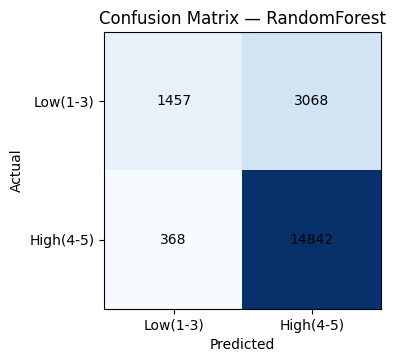


Top features — RandomForest
                    feature  importance
              eta_diff_days    0.112484
  purchase_to_delivery_days    0.095680
   purchase_to_carrier_days    0.064825
    cust_seller_distance_km    0.057614
              payment_total    0.050160
              total_freight    0.049843
             delivered_flag    0.042832
           product_weight_g    0.042638
             avg_item_price    0.042463
                total_price    0.042224
             max_item_price    0.041913
          product_height_cm    0.035790
          product_length_cm    0.034054
           product_width_cm    0.033796
             purchase_month    0.032830
                  late_flag    0.032816
               purchase_dow    0.029395
                    n_items    0.012715
              purchase_year    0.008449
primary_payment_credit_card    0.007485


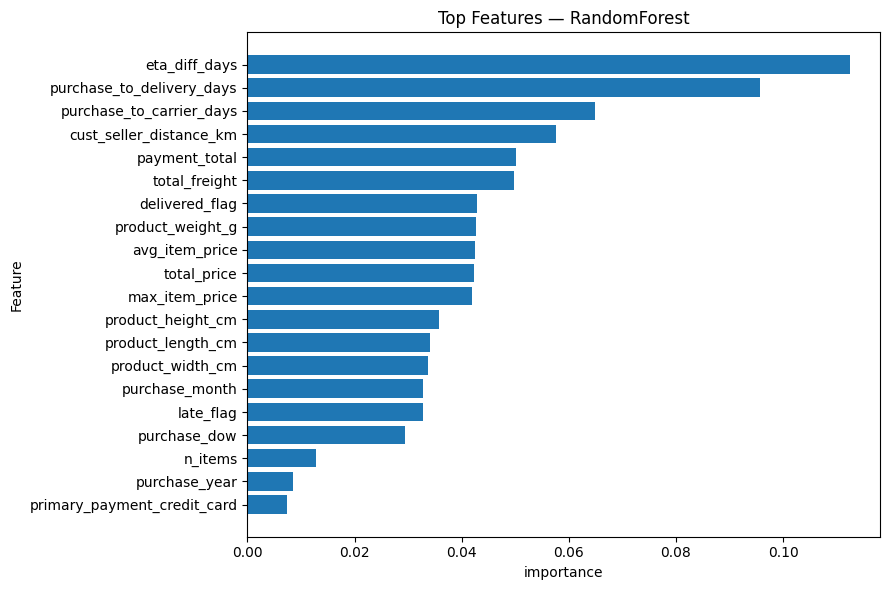


Top features — ExtraTrees
                    feature  importance
                  late_flag    0.071550
  purchase_to_delivery_days    0.065423
             delivered_flag    0.064630
              eta_diff_days    0.060984
   purchase_to_carrier_days    0.050719
    cust_seller_distance_km    0.047213
              payment_total    0.043087
              total_freight    0.042928
             purchase_month    0.040627
               purchase_dow    0.040364
           product_weight_g    0.039656
                total_price    0.038854
             avg_item_price    0.038687
             max_item_price    0.038528
          product_height_cm    0.037220
           product_width_cm    0.037099
          product_length_cm    0.036474
                    n_items    0.020057
              purchase_year    0.013192
primary_payment_credit_card    0.009423


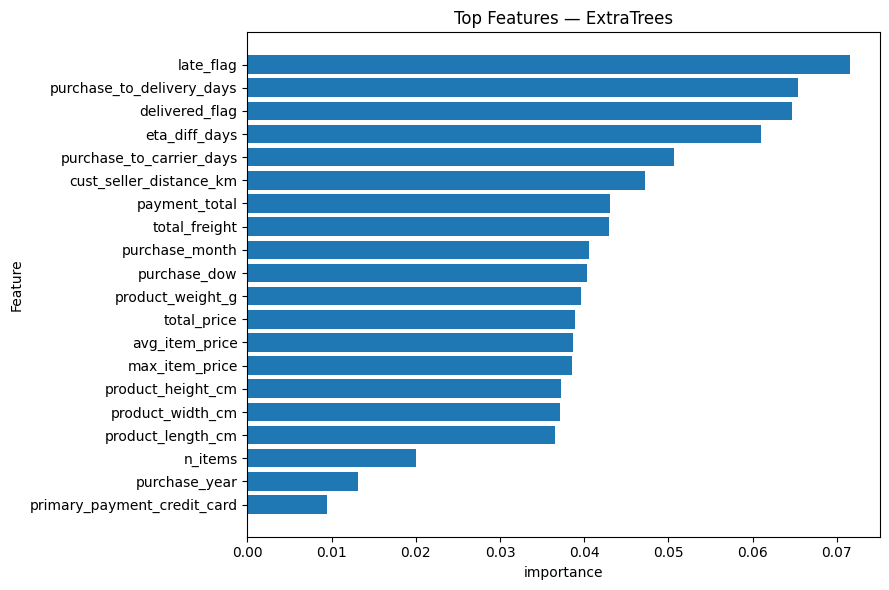


Top features — LogReg(L2)
                             feature   |coef|
                      avg_item_price 1.298866
                      max_item_price 1.228782
  category_en_books_general_interest 1.089389
         category_en_books_technical 0.666094
                   category_en_audio 0.576334
                      delivered_flag 0.573617
         category_en_fixed_telephony 0.516699
            category_en_home_confort 0.509007
                   customer_state_AM 0.496697
           purchase_to_delivery_days 0.468885
                           late_flag 0.356318
              primary_payment_boleto 0.345834
               category_en_computers 0.341544
                  category_en_drinks 0.330770
                     category_en_art 0.326147
              category_en_stationery 0.322944
                    category_en_food 0.314553
category_en_costruction_tools_garden 0.312274
                   customer_state_AP 0.309840
              category_en_food_drink 0.284463


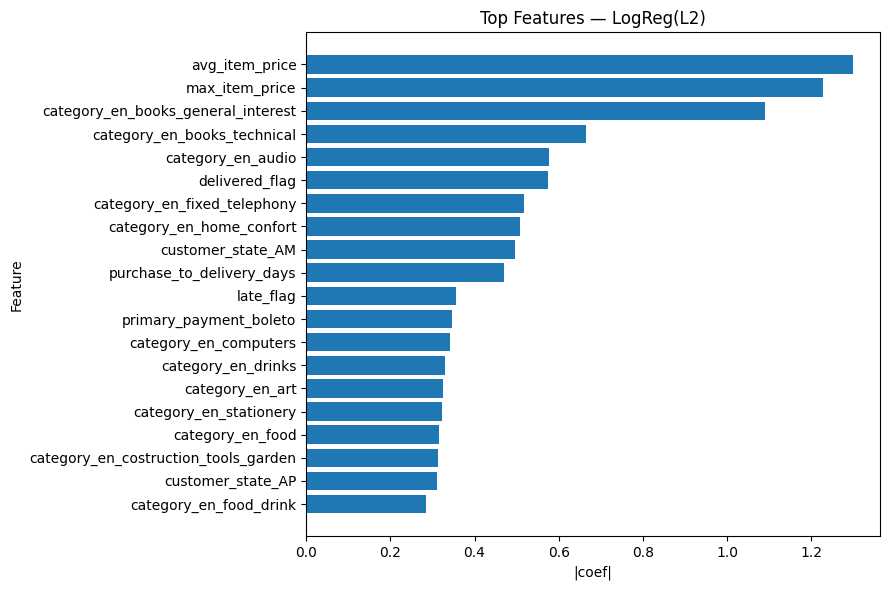

In [47]:
# ===============================================
# Model zoo comparison with the SAME preprocessing
# ===============================================


# Optional libraries (skip gracefully if missing)
have_lgbm = have_xgb = have_cat = True
try:
    from lightgbm import LGBMClassifier
except Exception:
    have_lgbm = False
try:
    from xgboost import XGBClassifier
except Exception:
    have_xgb = False
try:
    from catboost import CatBoostClassifier
except Exception:
    have_cat = False

# ---------- Safety check ----------
for v in ["feat", "numeric_features", "categorical_features"]:
    if v not in globals():
        raise RuntimeError(
            f"Missing `{v}`. Please run the feature-engineering cell first to create feat, "
            f"numeric_features, categorical_features."
        )

# ---------- Data split ----------
X = feat[numeric_features + categorical_features]
y = feat["label_high"].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

# ---------- Version-safe OneHotEncoder ----------
ohe_params = {"handle_unknown": "ignore", "max_categories": 50}
if "sparse_output" in inspect.signature(OneHotEncoder).parameters:
    ohe_params["sparse_output"] = False   # sklearn >= 1.2
else:
    ohe_params["sparse"] = False          # sklearn < 1.2

# ---------- Preprocessing: same base for all ----------
num_impute = SimpleImputer(strategy="median")
cat_impute = SimpleImputer(strategy="most_frequent")
ohe        = OneHotEncoder(**ohe_params)

# Tree models do not need scaling
preprocess_tree = ColumnTransformer(
    transformers=[
        ("num", Pipeline([("imputer", num_impute)]), numeric_features),
        ("cat", Pipeline([("imputer", cat_impute), ("onehot", ohe)]), categorical_features)
    ]
)

# Linear model benefits from scaling numerics; keep cats OHE
preprocess_linear = ColumnTransformer(
    transformers=[
        ("num", Pipeline([("imputer", num_impute), ("scaler", StandardScaler())]), numeric_features),
        ("cat", Pipeline([("imputer", cat_impute), ("onehot", ohe)]), categorical_features)
    ]
)

# ---------- Model definitions ----------
models = {
    "RandomForest": RandomForestClassifier(n_estimators=300, n_jobs=-1, random_state=42),
    "ExtraTrees"  : ExtraTreesClassifier(n_estimators=400, n_jobs=-1, random_state=42),
    "LogReg(L2)"  : LogisticRegression(max_iter=2000, n_jobs=-1, solver="lbfgs")
}

if have_lgbm:
    models["LightGBM"] = LGBMClassifier(
        n_estimators=600, learning_rate=0.05, num_leaves=31, subsample=0.8,
        colsample_bytree=0.8, random_state=42
    )
if have_xgb:
    models["XGBoost"] = XGBClassifier(
        n_estimators=600, learning_rate=0.05, max_depth=6, subsample=0.8,
        colsample_bytree=0.8, reg_lambda=1.0, random_state=42, n_jobs=-1,
        eval_metric="logloss"
    )
if have_cat:
    models["CatBoost"] = CatBoostClassifier(
        iterations=600, learning_rate=0.05, depth=6, l2_leaf_reg=3.0,
        random_state=42, verbose=False
    )

# ---------- Helpers ----------
def fit_eval(name, estimator, linear=False):
    """Fit model in a pipeline with shared preprocessing; return metrics and fitted pipeline."""
    pipe = Pipeline([
        ("preprocess", preprocess_linear if linear else preprocess_tree),
        ("model", estimator)
    ])
    pipe.fit(X_train, y_train)
    proba = None
    if hasattr(pipe.named_steps["model"], "predict_proba"):
        proba = pipe.predict_proba(X_test)[:, 1]
    y_pred = pipe.predict(X_test)

    metrics = {
        "model": name,
        "accuracy": accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred, zero_division=0),
        "recall": recall_score(y_test, y_pred, zero_division=0),
        "f1": f1_score(y_test, y_pred, zero_division=0),
        "roc_auc": roc_auc_score(y_test, proba) if proba is not None else np.nan
    }
    return metrics, pipe

def get_feature_names(fitted_pipe):
    ohe = fitted_pipe.named_steps["preprocess"].named_transformers_["cat"].named_steps["onehot"]
    cat_names = list(ohe.get_feature_names_out(categorical_features))
    return numeric_features + cat_names

def feature_importance(fitted_pipe, topn=20):
    mdl = fitted_pipe.named_steps["model"]
    names = get_feature_names(fitted_pipe)
    if hasattr(mdl, "feature_importances_"):
        vals = mdl.feature_importances_
        src = "importance"
    elif hasattr(mdl, "coef_"):
        # For binary logistic regression, coef_.shape = (1, n_features)
        vals = np.ravel(mdl.coef_)
        vals = np.abs(vals)  # magnitude for ranking
        src = "|coef|"
    else:
        return None
    fi = pd.DataFrame({"feature": names, src: vals}).sort_values(by=src, ascending=False)
    return fi.head(topn)

# ---------- Train & compare ----------
rows = []
fitted = {}
for name, est in models.items():
    is_linear = name.startswith("LogReg")
    m, pipe = fit_eval(name, est, linear=is_linear)
    rows.append(m)
    fitted[name] = pipe
    print(f"Trained: {name}")

results = pd.DataFrame(rows).sort_values(["f1","roc_auc","accuracy"], ascending=False)
print("\n=== Model comparison (higher is better) ===")
print(results.to_string(index=False))

# ---------- Confusion matrix for best model ----------
best_name = results.iloc[0]["model"]
best_pipe = fitted[best_name]
y_pred_best = best_pipe.predict(X_test)
cm = confusion_matrix(y_test, y_pred_best)
print(f"\nBest model: {best_name}")
print("Confusion matrix [[TN, FP], [FN, TP]]:\n", cm)
print("\nClassification report:\n", classification_report(y_test, y_pred_best, digits=3))

plt.figure(figsize=(4,4))
plt.imshow(cm, cmap="Blues")
plt.title(f"Confusion Matrix — {best_name}")
plt.xlabel("Predicted")
plt.ylabel("Actual")
for (i, j), val in np.ndenumerate(cm):
    plt.text(j, i, f"{val}", ha="center", va="center")
plt.xticks([0,1], ["Low(1-3)","High(4-5)"])
plt.yticks([0,1], ["Low(1-3)","High(4-5)"])
plt.tight_layout()
plt.show()

# ---------- Feature importance for each model ----------
for name, pipe in fitted.items():
    fi = feature_importance(pipe, topn=20)
    if fi is None:
        continue
    print(f"\nTop features — {name}")
    print(fi.to_string(index=False))
    # quick bar plot
    col = [c for c in fi.columns if c != "feature"][0]
    plt.figure(figsize=(9,6))
    plt.barh(fi["feature"][::-1], fi[col][::-1])
    plt.xlabel(col)
    plt.ylabel("Feature")
    plt.title(f"Top Features — {name}")
    plt.tight_layout()
    plt.show()


## Model Comparison Findings

### 1. Overall Performance
- **RandomForest** achieved the best overall performance with:
  - **Accuracy:** 82.6%
  - **F1-score (class 1 focus):** 0.896
  - **ROC-AUC:** 0.735
- **Logistic Regression (L2)** and **ExtraTrees** were close in performance, differing by less than 1% in most metrics.

### 2. Class-wise Performance
- **High-score reviews (4–5)** (Class 1):
  - **Recall:** 97.6% — model captures almost all high-score cases.
  - **Precision:** 82.9% — most predictions of high-score are correct.
- **Low-score reviews (1–3)** (Class 0):
  - **Recall:** 32.2% — model misses the majority of low-score cases.
  - **Precision:** 79.8% — when it predicts low-score, it’s often correct.

### 3. Observations
- The **confusion matrix** shows a large number of false negatives for class 0 (low-score reviews being classified as high).
- This indicates a **class imbalance problem**: the dataset is heavily skewed toward high review scores.
- The model is biased toward predicting high scores, achieving high recall for class 1 but poor recall for class 0.
- In this business context, **false high ratings are more costly** because they mask dissatisfied customers and prevent corrective action.  
  → Therefore, **precision for class 1** (high-score predictions) and **recall for class 0** (catching low scores) are the most critical metrics.

### 4. Recommendations
- Address the imbalance using:
  - **Resampling techniques** (SMOTE, undersampling).
  - **Class weighting** in model training (`class_weight='balanced'`).
  - Threshold tuning to improve recall for low scores.
- Re-run the model with these adjustments and compare the trade-offs between precision and recall.
